<a href="https://colab.research.google.com/github/notKguin/MMK-Informservice/blob/main/final_project/project/ML_intensive_final_project_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2155]:
%config InlineBackend.figure_format='retina'

## Импорт библиотек

In [2156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler

# Загрузка датасета

In [2157]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2158]:
df_chugun = pd.read_csv('/content/drive/MyDrive/MMK_inforservice/datasets/ML_intensive_final_project_correlation_chugun.csv')

In [2159]:
df_coke = pd.read_csv('/content/drive/MyDrive/MMK_inforservice/datasets/ML_intensive_final_project_correlation_coke.csv')

## Разделение данных для «Количество чугуна (т)»

In [2160]:
target_1 = 'Количество чугуна (т)'
X_chugun = df_chugun.drop(target_1, axis=1)
y_chugun = df_chugun[target_1]

In [2161]:
X_chugun

,Перепад давлений общий (ат),Перепад давлений нижний (ат),Расход природного газа (м³/ч),Расход холодного дутья (м³/ч),Выход колошникового газа (м³/ч),Колошниковый газ (H₂),O₂ в горячем дутье,t колошникового газа 2 (°С),t колошникового газа 1 (°С),Уровень засыпи (север) (м),t периферийных газов 5 (°С),t колошникового газа 4 (°С),t колошникового газа 3 (°С),Уровень засыпи (запад) (м),Уровень засыпи (восток) (м)
0,1.263071,0.961892,15916.95805,214677.1855,307399.0456,7.333333,27.333333,175.343535,169.780254,1.117374,548.700886,177.223895,207.139783,1.007742,1.336937
1,1.251254,0.961920,15998.28292,214572.0651,309399.2344,7.400000,27.233334,173.247252,169.744034,1.348690,454.277882,169.717391,197.426498,1.212071,1.609969
2,1.266771,0.978648,15984.38981,216907.2760,311839.3307,7.566667,27.166667,166.500430,165.301828,1.173403,474.516290,167.865357,197.474940,1.033959,1.434564
3,1.287075,0.990443,15975.46354,217341.6706,312108.1797,7.566667,26.833333,159.559399,157.926989,1.122214,417.403557,160.266282,189.962570,1.019543,1.313145
4,1.259818,0.960610,15999.31665,223169.5814,319017.8099,7.633333,27.000000,152.145464,149.805531,0.951920,460.531086,150.332654,190.805077,0.825335,1.204589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,1.415406,1.114516,29951.71387,264492.2077,418289.3203,9.133333,28.066666,205.292570,182.717968,0.687760,604.460844,200.579594,217.471577,0.872599,0.906697
1549,1.410153,1.138146,29905.31812,268069.9850,421993.7734,9.200000,27.800000,206.771612,180.412993,0.720157,681.810364,195.448180,213.503799,0.913131,0.962914
1550,1.383210,1.123840,29838.85042,267186.0690,422974.8932,8.933333,27.866666,193.907042,183.169431,0.736799,586.472270,184.781951,198.085548,0.938502,0.926343
1551,1.406916,1.134008,29622.66935,266981.6263,423700.3086,9.133333,27.900000,183.356454,179.703309,0.703867,420.091742,181.961369,189.198069,0.919194,0.892051


## Разделение данных для «Удельный расход кокса (кг/т)»

In [2162]:
target_2 = 'Удельный расход кокса (кг/т)'
X_coke = df_coke.drop(target_2, axis=1)
y_coke = df_coke[target_2]

## Функция для вычисления и вывода метрик модели

In [2163]:
def evaluate_model(y_test, y_pred, verbose=True):
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred) * 100,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    if verbose:
        print("Метрики модели:")
        print(f"MAE: {metrics['MAE']:.2f}")
        print(f"MSE: {metrics['MSE']:.2f}")
        print(f"MAPE: {metrics['MAPE']:.2f}%")
        print(f"RMSE: {metrics['RMSE']:.2f}")
        print(f"R²: {metrics['R2']:.2f}")

    return metrics

# Модели для таргета «Количество чугуна (т)»

## Масштабирование признаков

In [2164]:
X_train, X_test, y_train, y_test = train_test_split(X_chugun, y_chugun, test_size=0.2, random_state=42)

In [2165]:
scaler = StandardScaler()

In [2166]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Линейная регрессия

### Обучение модели и вывод метрик

In [2167]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [2168]:
y_pred = model.predict(X_test)

In [2169]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 121.87
MSE: 25881.51
MAPE: 2.70%
RMSE: 160.88
R²: 0.94


### График Прогноз-Факт

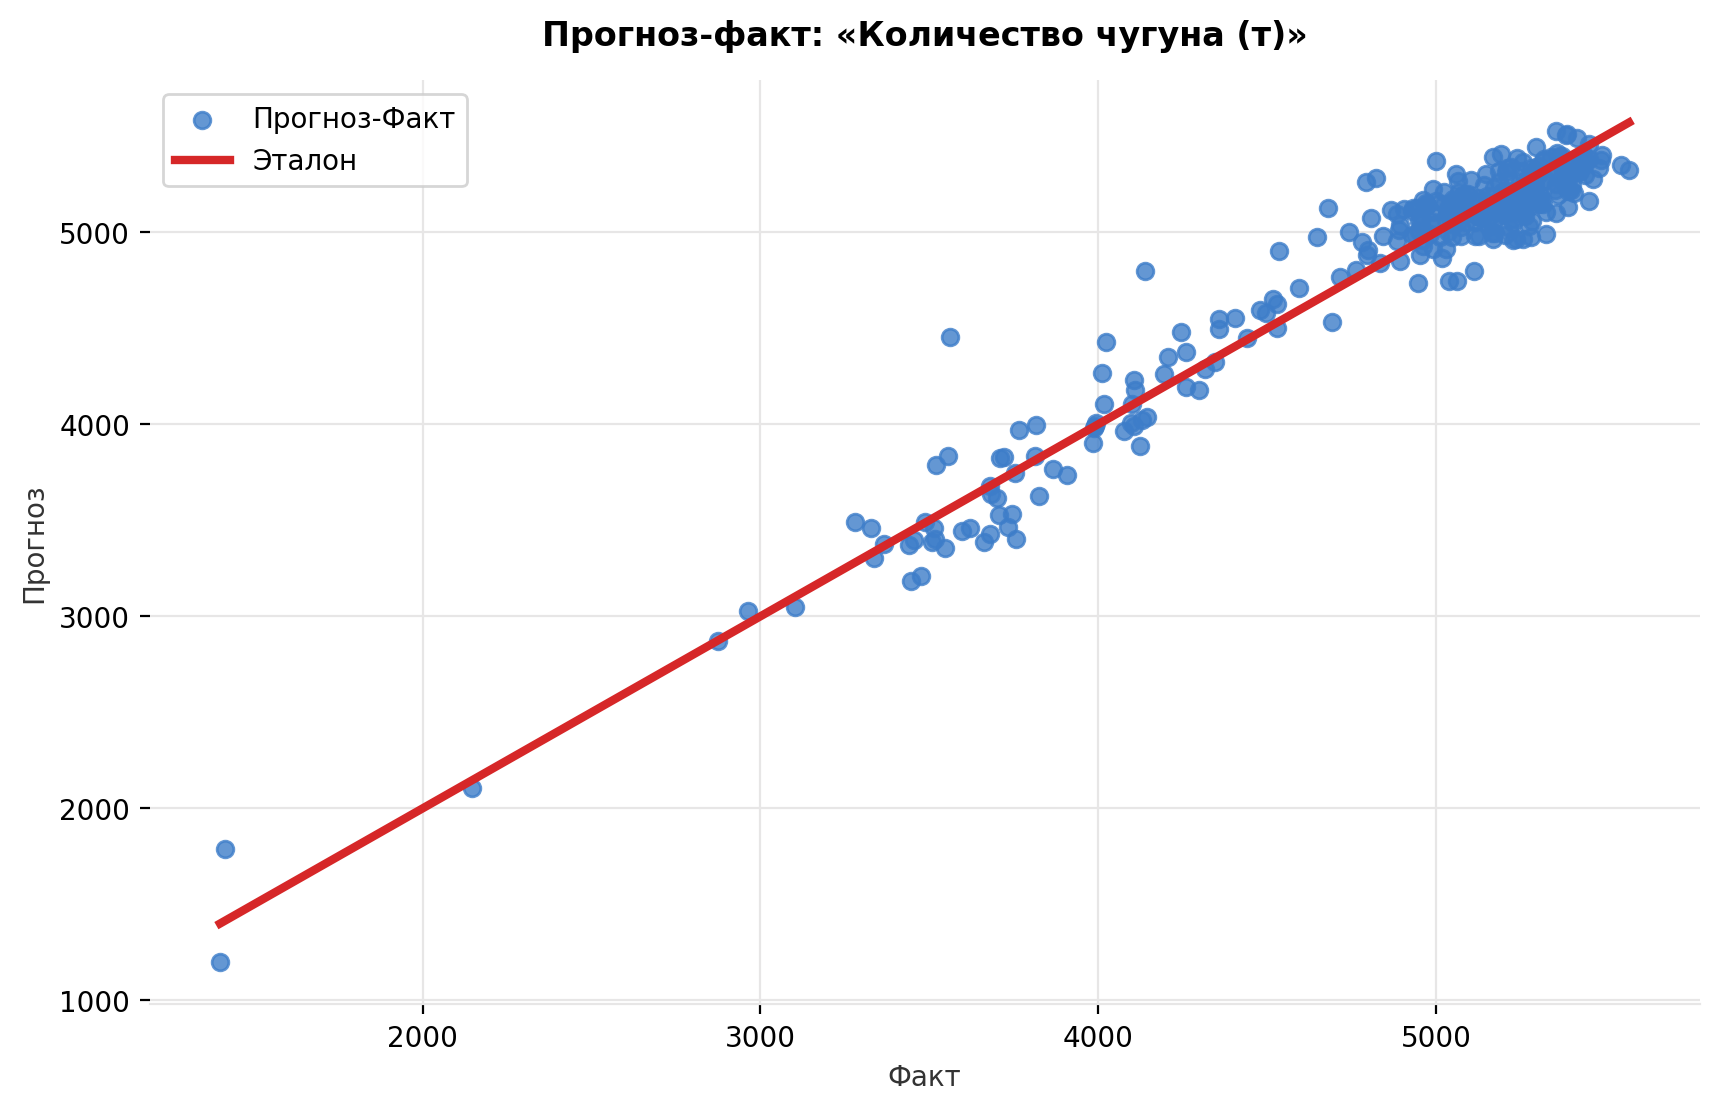

In [2170]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#3D7DC9', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel('Факт', y=1.02, alpha=0.8)
plt.ylabel('Прогноз', x=1.02, alpha=0.8)
plt.title('Прогноз-факт: «Количество чугуна (т)»', weight='bold', y=1.02)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.grid(True, color='#E7E6E6')

plt.show()

### График влияния признаков

In [2171]:
coefficients = pd.DataFrame({'Признак': X_chugun.columns,'Коэффициент': model.coef_}).sort_values(by='Коэффициент', ascending=True)

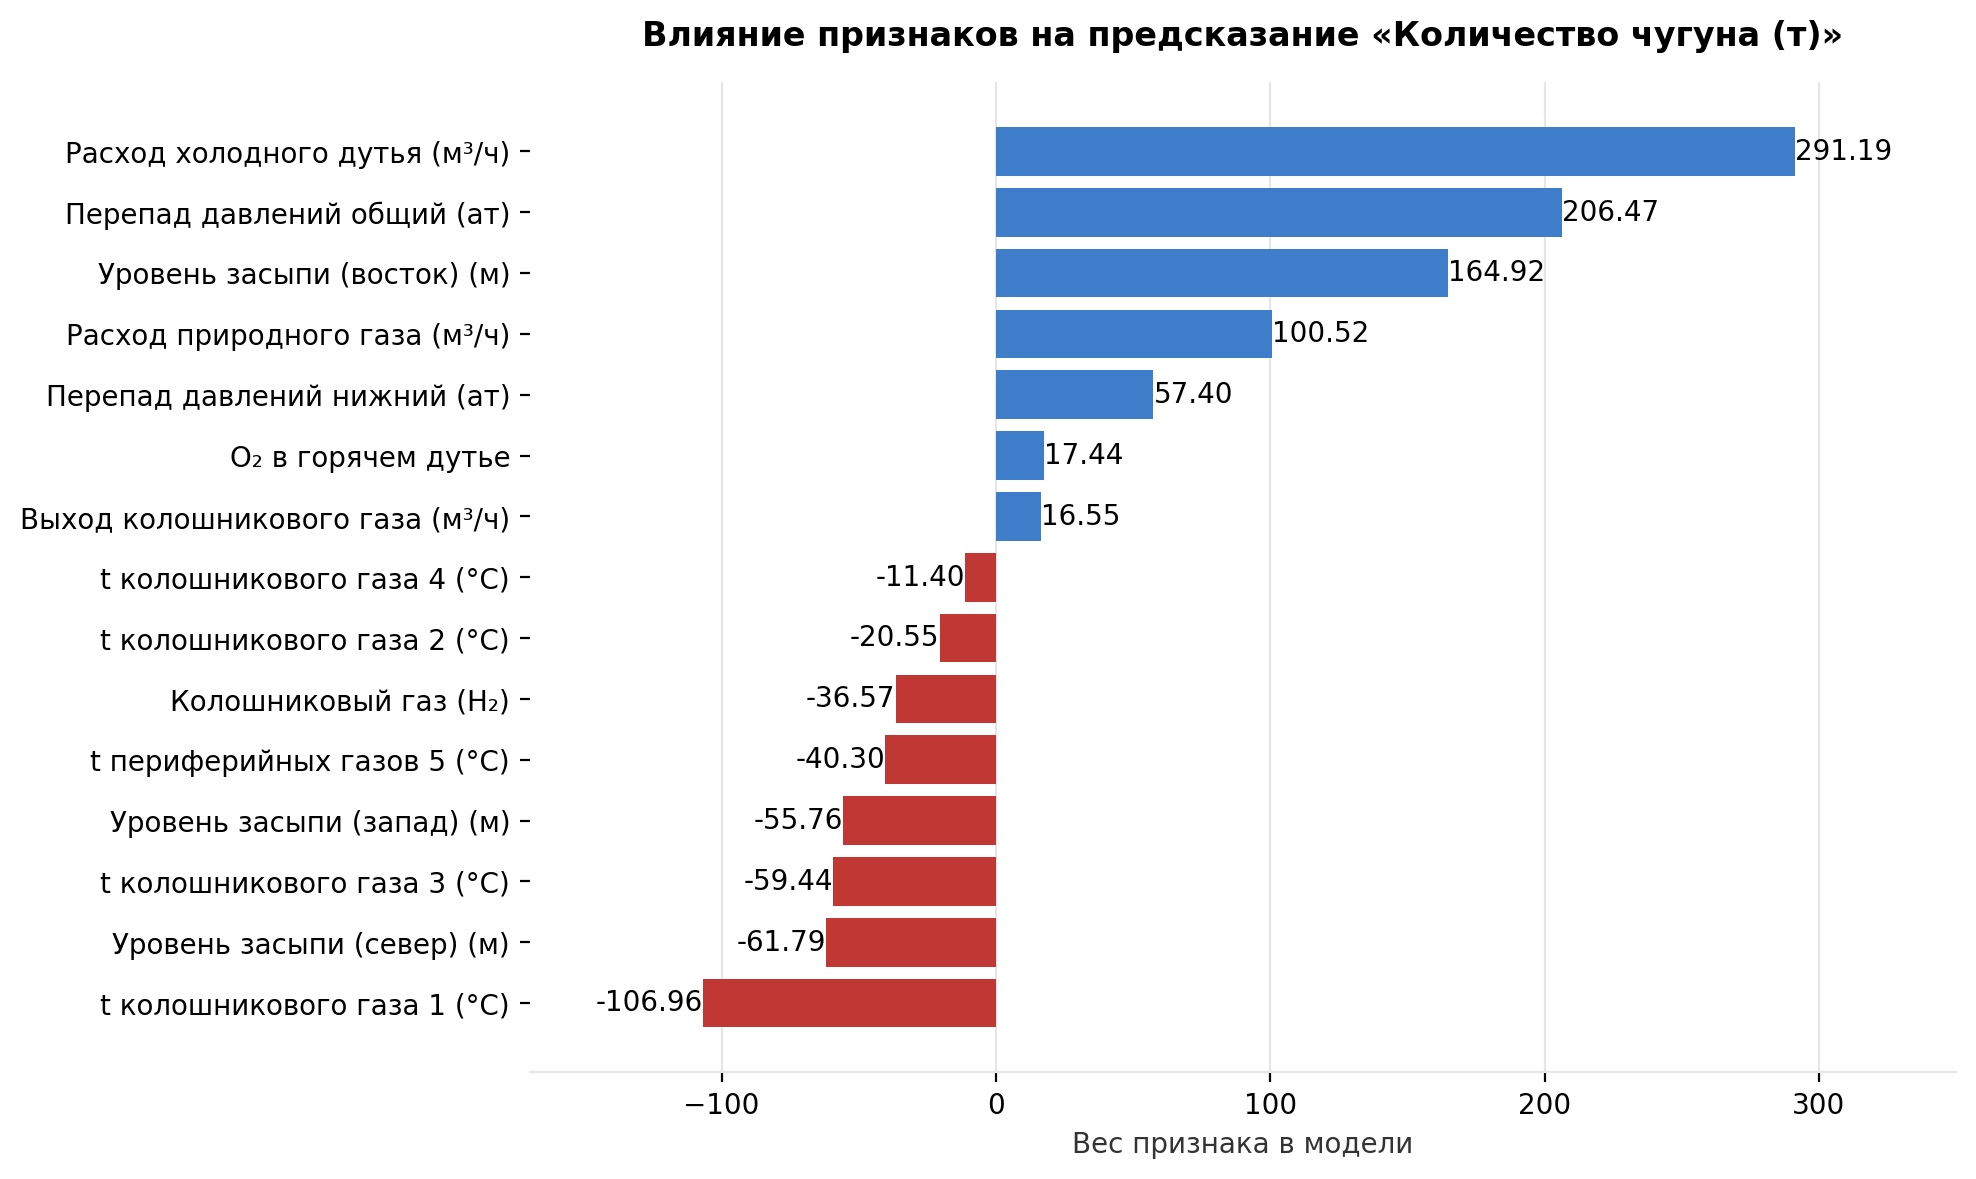

In [2172]:
plt.figure(figsize=(10, 6))
plt.xlim(-170, 350)

colors = ['#3D7DC9' if x >= 0 else '#C13733' for x in coefficients['Коэффициент']]
bars = plt.barh(coefficients['Признак'], coefficients['Коэффициент'], color=colors)

for bar in bars:
    width = bar.get_width()
    align = 'left' if width > 0 else 'right'
    offset = 0.01 if width > 0 else -0.01
    plt.text(width + offset, bar.get_y() + bar.get_height()/2, f'{width:.2f}', ha=align, va='center')

plt.xlabel('Вес признака в модели', y=1.02, alpha=0.8)
plt.title('Влияние признаков на предсказание «Количество чугуна (т)»', weight='bold', y=1.02)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.xaxis.grid(True, color='#E7E6E6')

plt.tight_layout()
plt.show()

## Дерево решений

### Подбор гиперпараметров

In [2173]:
tree_model = DecisionTreeRegressor(random_state=42)

In [2174]:
# param_grid = {
#     'max_depth': [8, 9, 10],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [9, 10, 11]
# }

In [2175]:
best_params = {
    'max_depth': [9],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4],
    'min_samples_split': [10]
}

In [2176]:
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [2177]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10}

### Обучение модели и вывод метрик

In [2178]:
best_tree = grid_search.best_estimator_

In [2179]:
y_pred = best_tree.predict(X_test)

In [2180]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 137.64
MSE: 61297.01
MAPE: 3.64%
RMSE: 247.58
R²: 0.87


### График Прогноз-Факт

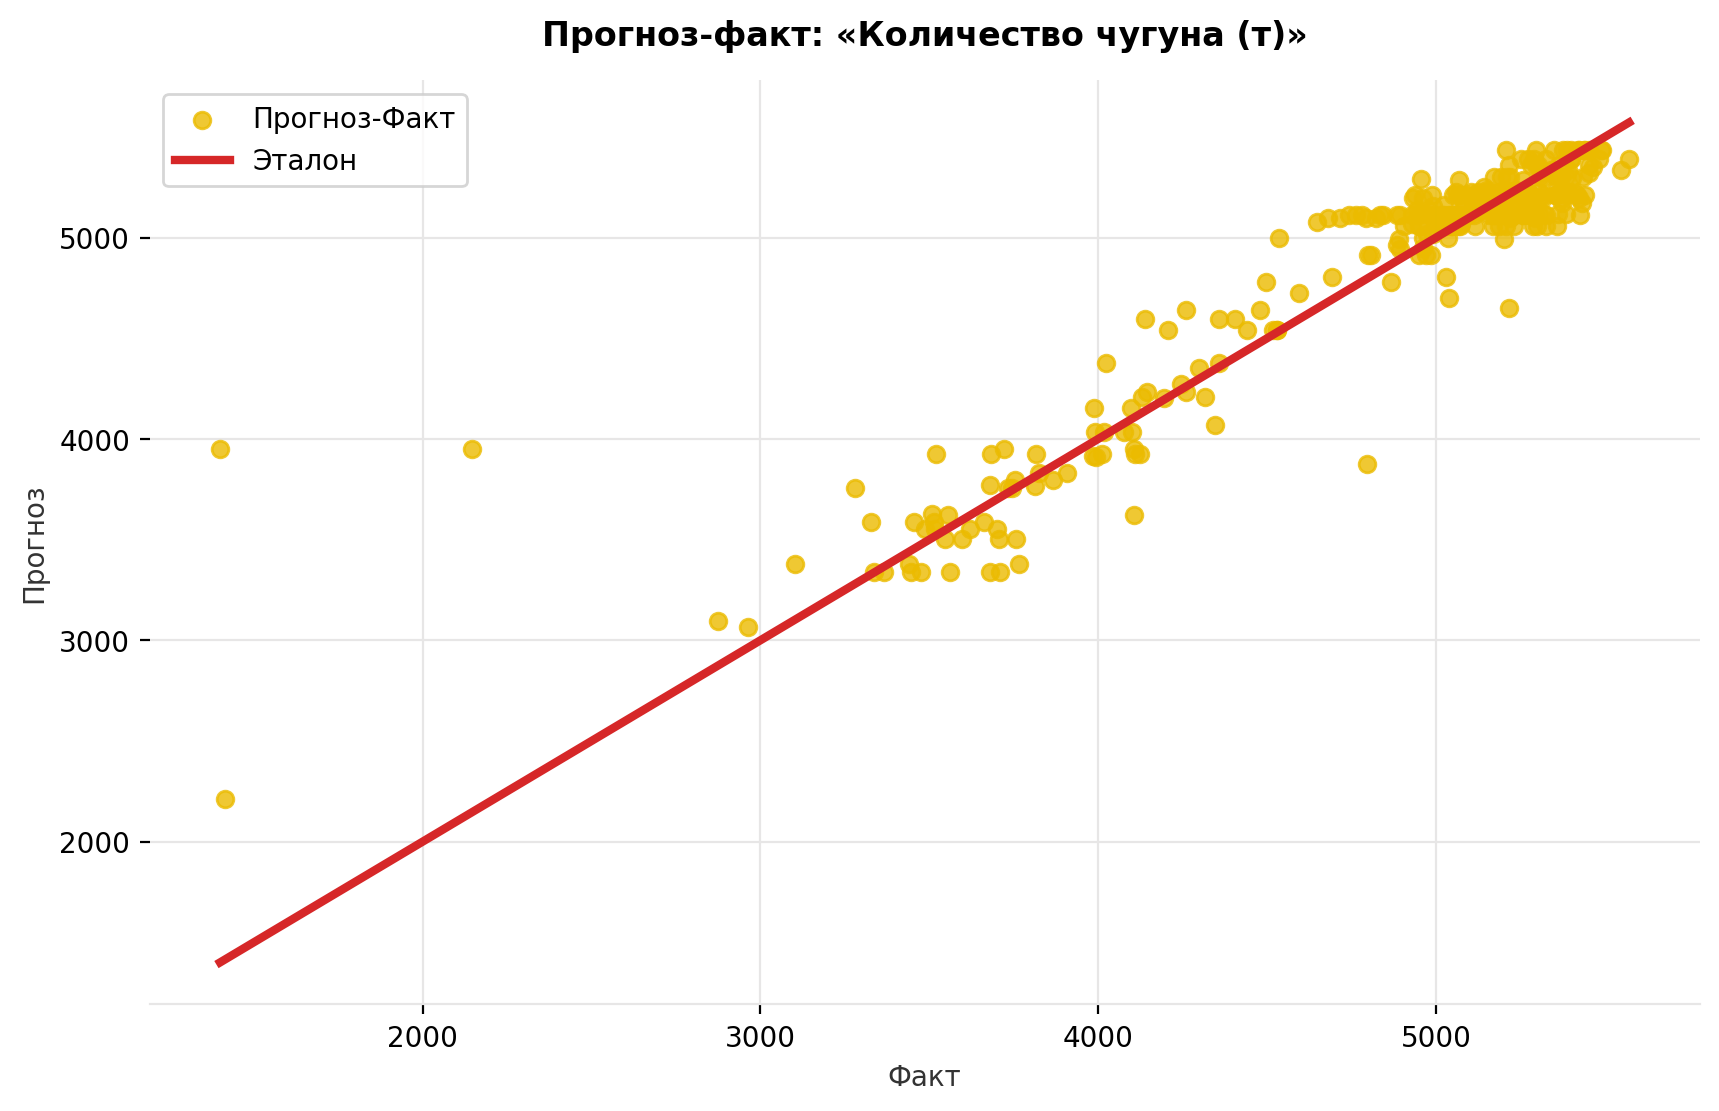

In [2181]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#EBBB00', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel('Факт', y=1.02, alpha=0.8)
plt.ylabel('Прогноз', x=1.02, alpha=0.8)
plt.title('Прогноз-факт: «Количество чугуна (т)»', weight='bold', y=1.02)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.grid(True, color='#E7E6E6')

plt.show()

### График важности признаков

In [2182]:
importance = pd.DataFrame({'Признак': X_chugun.columns, 'Важность': best_tree.feature_importances_}).sort_values('Важность', ascending=True)

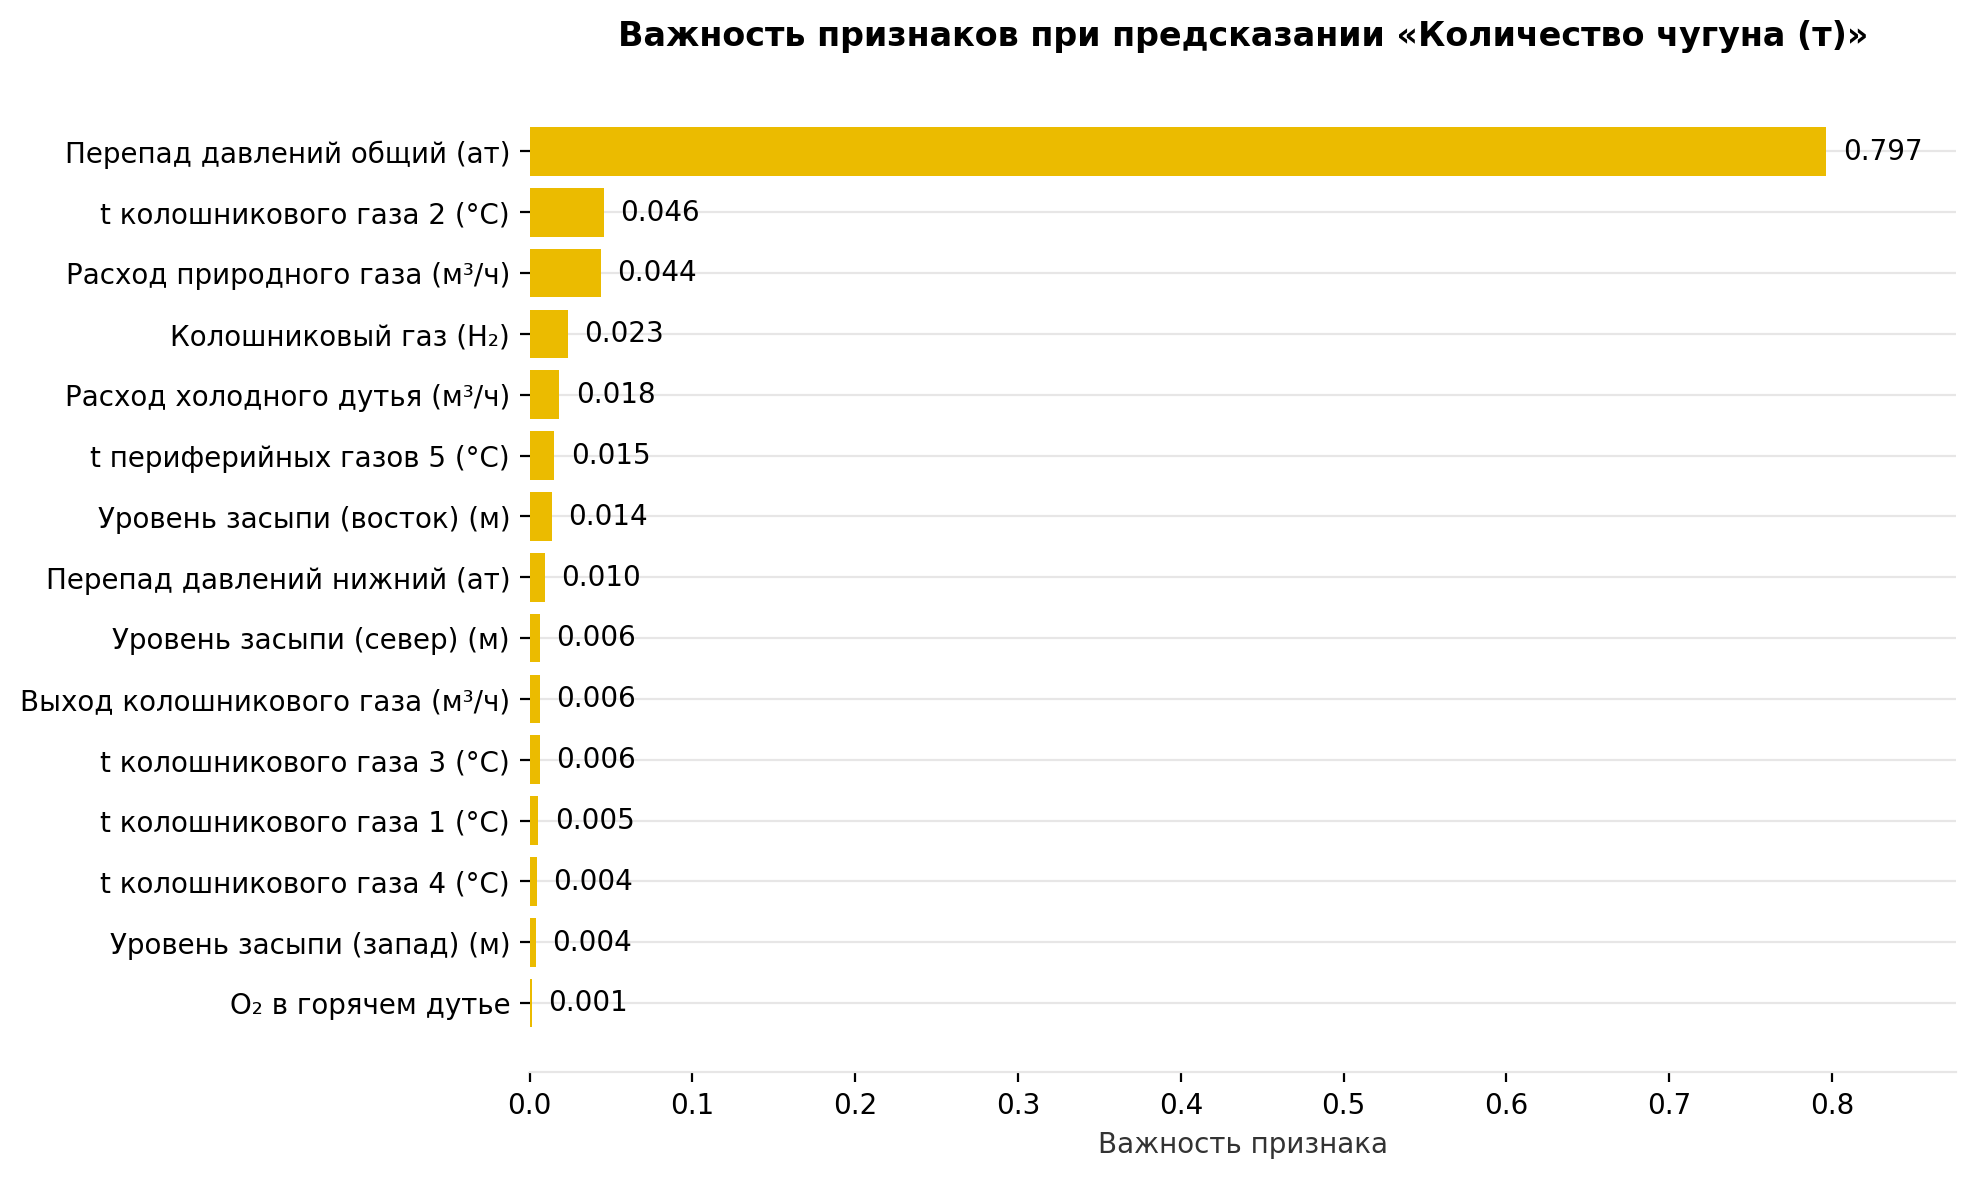

In [2183]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#EBBB00')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака', y=1.02, alpha=0.8)
plt.title('Важность признаков при предсказании «Количество чугуна (т)»', weight='bold', y=1.02)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')

plt.tight_layout()
plt.show()

### Визуализация дерева решений

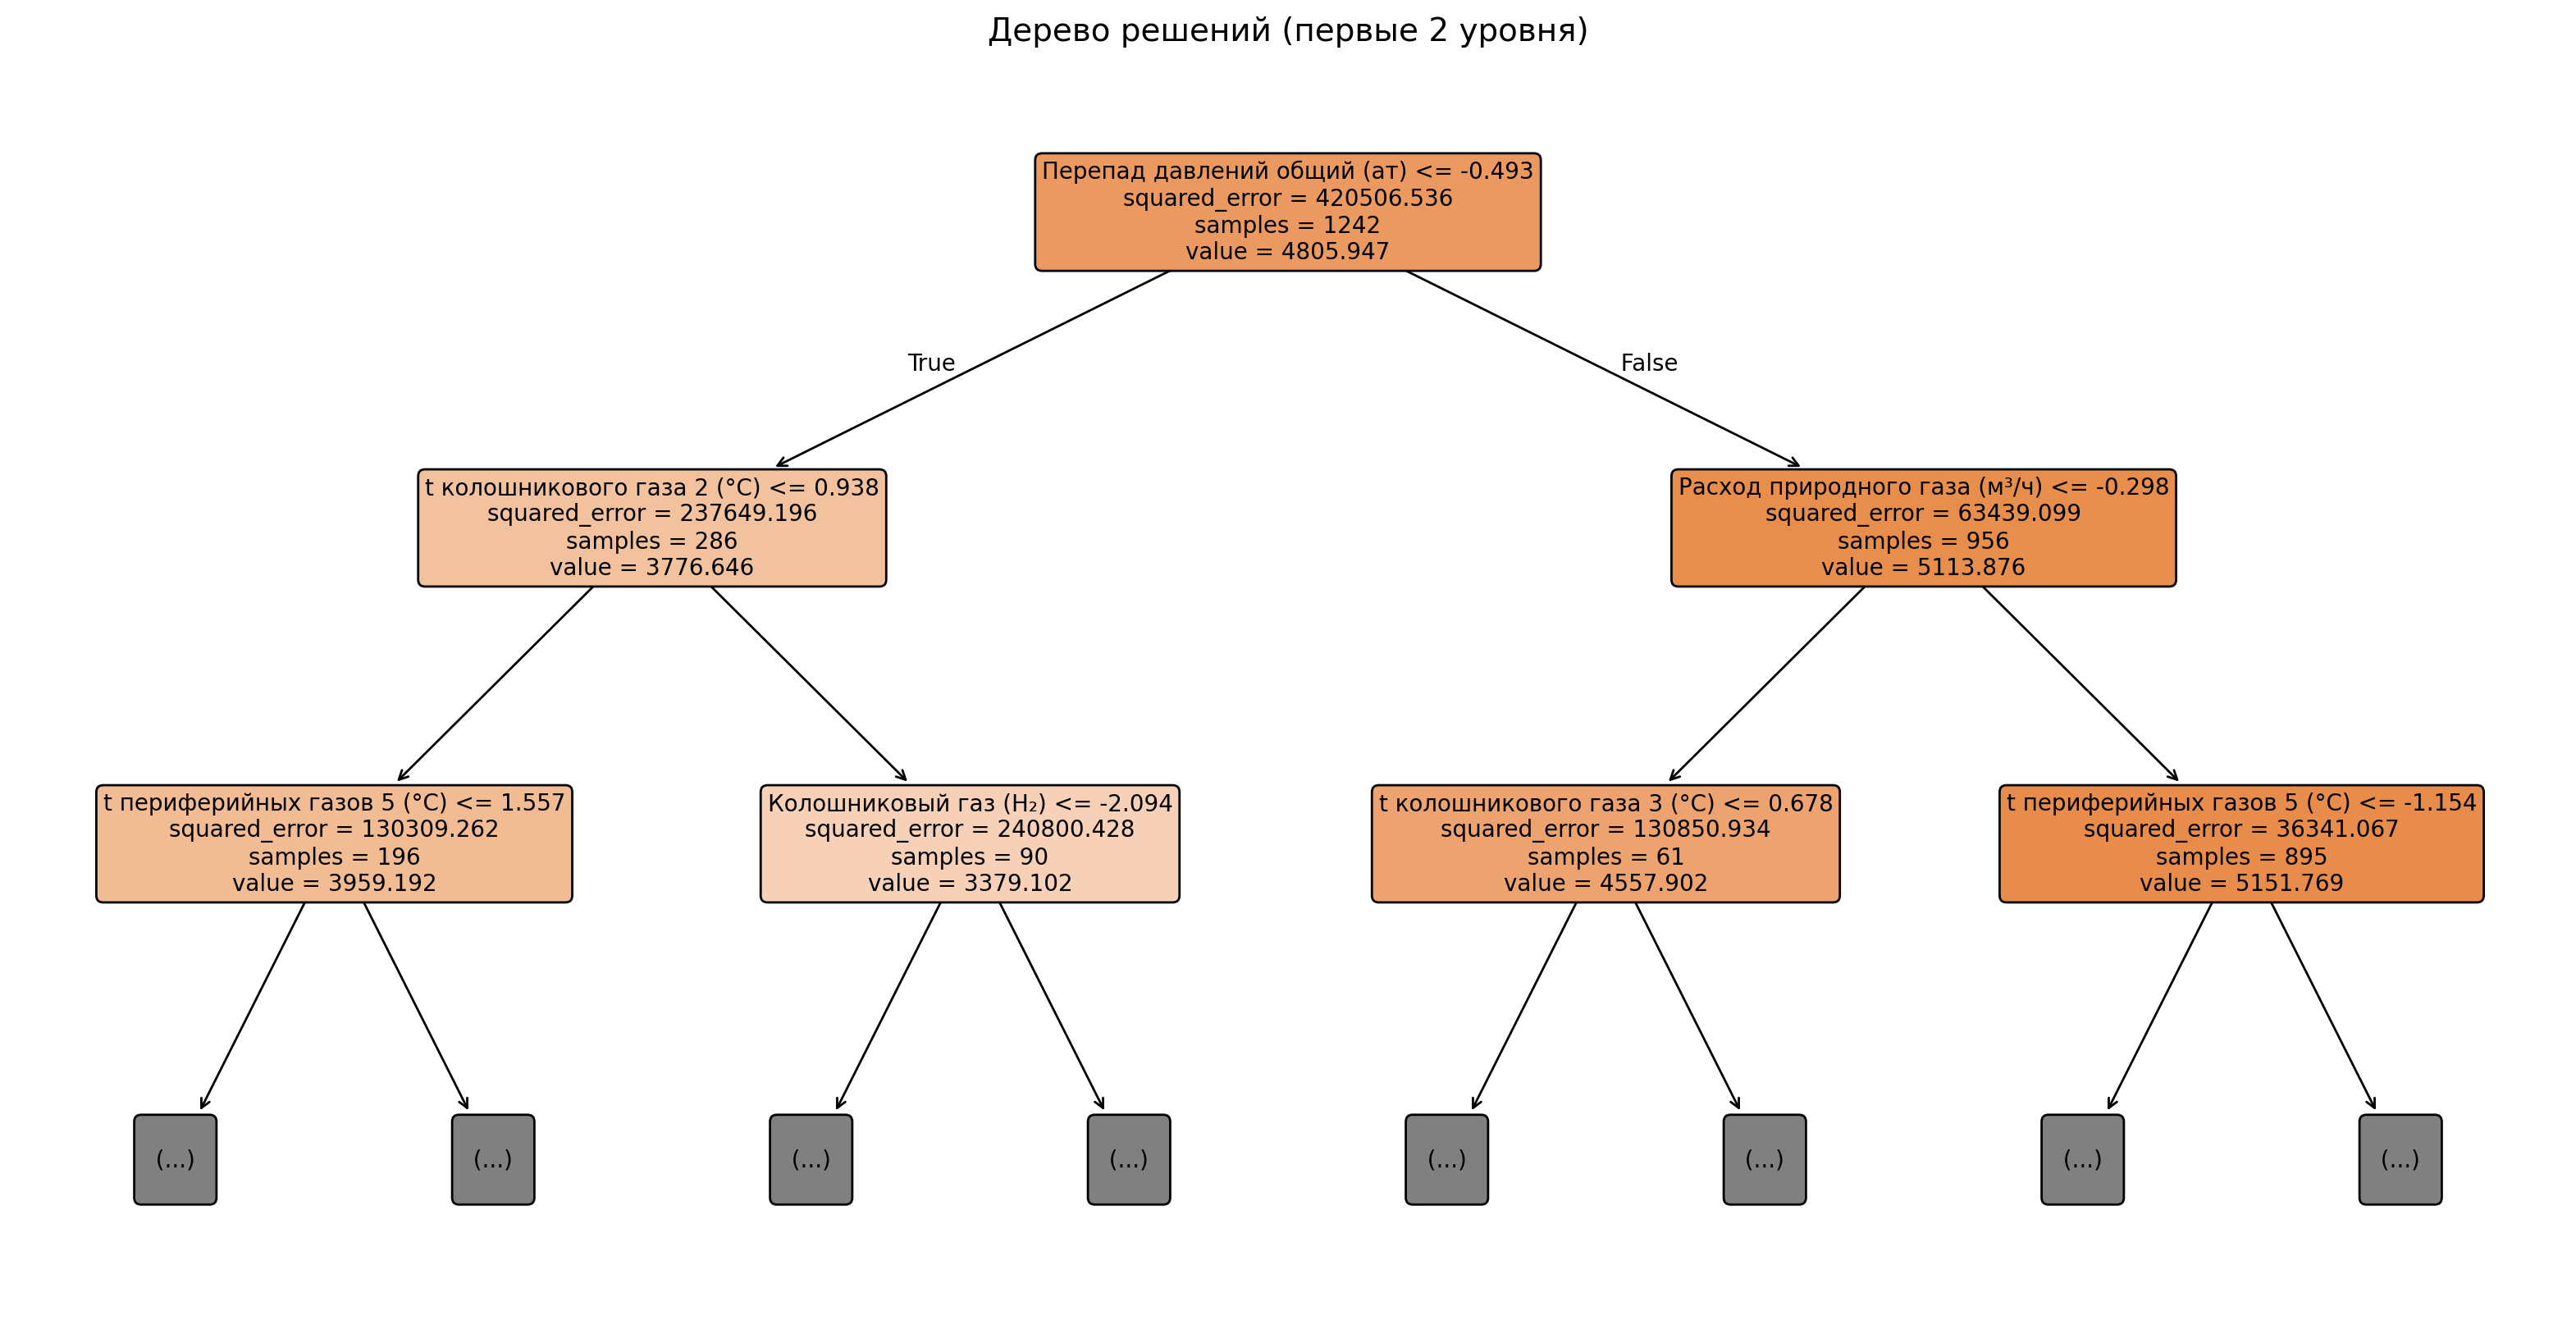

In [2184]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=importance['Признак'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=2,
)
plt.title("Дерево решений (первые 2 уровня)", fontsize=14)
plt.show()

## Градиентный бустинг

### Подбор гиперпараметров

In [2185]:
gb_model = GradientBoostingRegressor(random_state=42)

In [2186]:
# param_grid = {
#     'learning_rate': [0.08, 0.09, 0.1],
#     'max_depth': [3, 4, 5],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [9, 10, 11],
#     'n_estimators': [400, 450, 500]
# }

In [2187]:
best_params = {
    'learning_rate': [0.09],
    'max_depth': [4],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [10],
    'n_estimators': [450]
}

In [2188]:
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
)

In [2189]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.09], 'max_depth': [4],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [10], 'n_estimators': [450]},
             scoring='neg_mean_squared_error', verbose=1)

In [2190]:
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.09,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 450}

### Обучение модели и вывод метрик

In [2191]:
best_gb = grid_search.best_estimator_

In [2192]:
import pickle
from google.colab import files

with open('gb_model_chugun.pkl', 'wb') as f:
    pickle.dump(best_gb, f)

files.download('gb_model_chugun.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2193]:
y_pred = best_gb.predict(X_test)

In [2194]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 84.48
MSE: 14107.64
MAPE: 2.01%
RMSE: 118.78
R²: 0.97


### График Прогноз-Факт

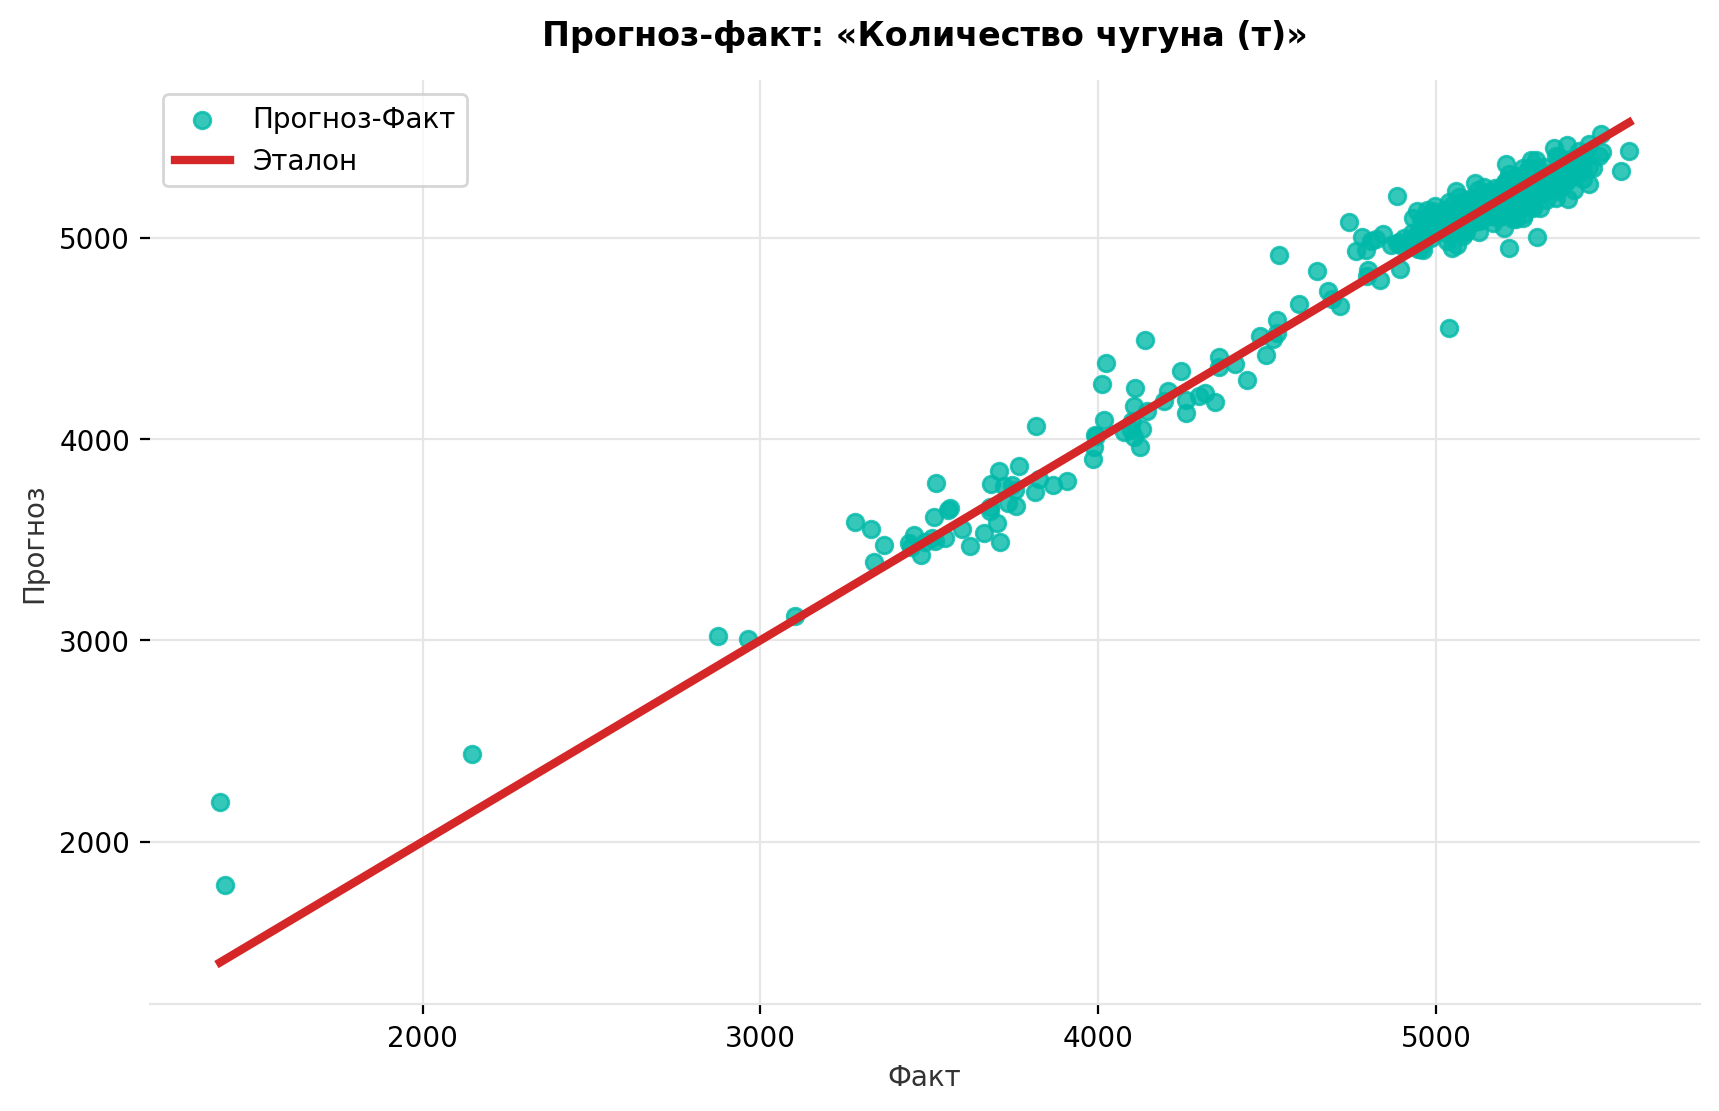

In [2195]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#01B9A9', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel('Факт', y=1.02, alpha=0.8)
plt.ylabel('Прогноз', x=1.02, alpha=0.8)
plt.title('Прогноз-факт: «Количество чугуна (т)»', weight='bold', y=1.02)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.grid(True, color='#E7E6E6')

plt.show()

### График важности признаков

In [2196]:
importance = pd.DataFrame({'Признак': X_chugun.columns, 'Важность': best_gb.feature_importances_}).sort_values('Важность', ascending=True)

In [2197]:
# importance = pd.DataFrame({'Признак': X_chugun.columns, 'Важность': best_gb.feature_importances_}).sort_values('Важность', ascending=True).tail(4)

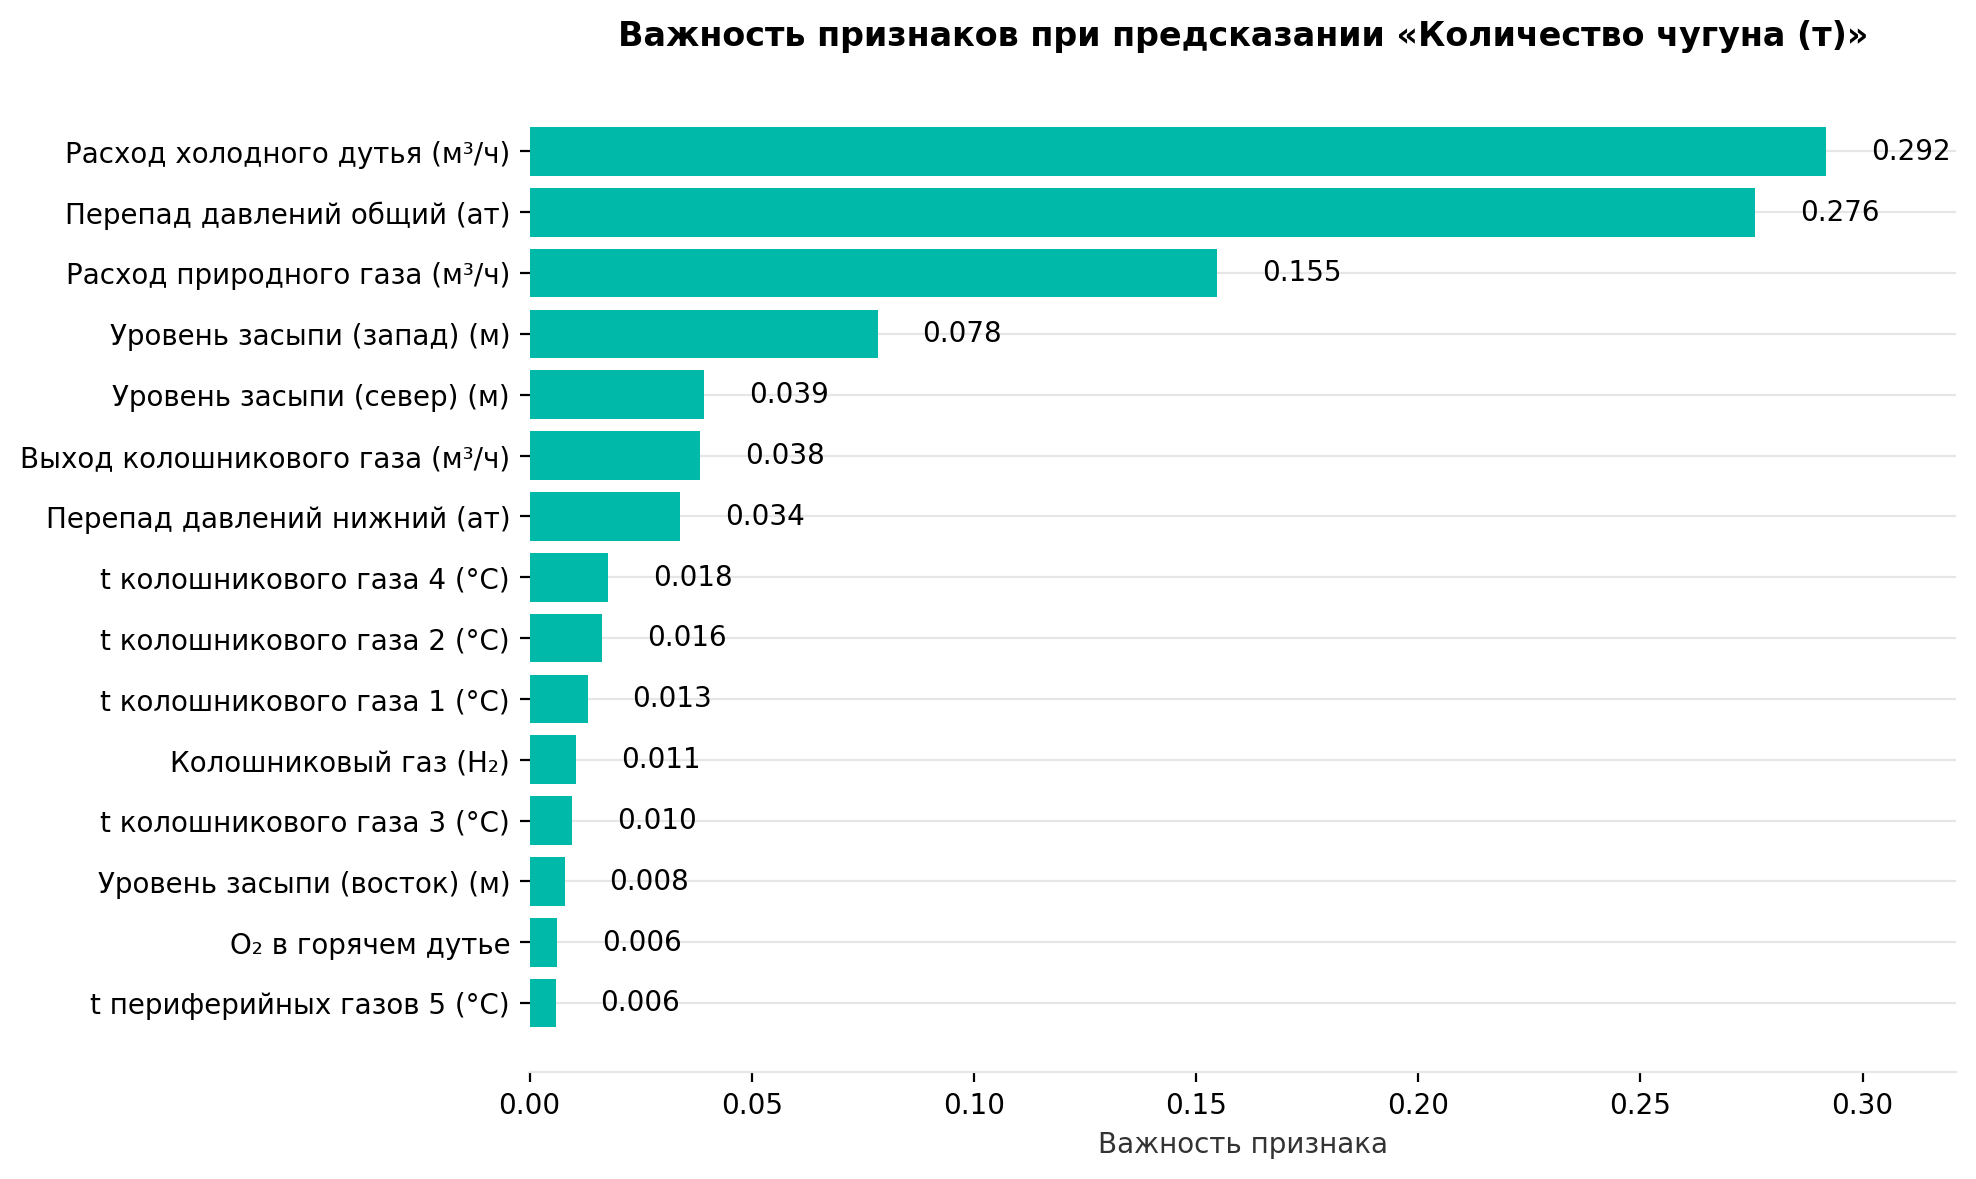

In [2198]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#01B9A9')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака', y=1.02, alpha=0.8)
plt.title('Важность признаков при предсказании «Количество чугуна (т)»', weight='bold', y=1.02)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')

plt.tight_layout()
plt.show()

## Сравнение метрик моделей

In [2199]:
y_pred_model = model.predict(X_test)
y_pred_tree = best_tree.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

In [2200]:
metrics_model = evaluate_model(y_test, y_pred_model)

Метрики модели:
MAE: 121.87
MSE: 25881.51
MAPE: 2.70%
RMSE: 160.88
R²: 0.94


In [2201]:
metrics_tree = evaluate_model(y_test, y_pred_tree)

Метрики модели:
MAE: 137.64
MSE: 61297.01
MAPE: 3.64%
RMSE: 247.58
R²: 0.87


In [2202]:
metrics_gb = evaluate_model(y_test, y_pred_gb)

Метрики модели:
MAE: 84.48
MSE: 14107.64
MAPE: 2.01%
RMSE: 118.78
R²: 0.97


In [2203]:
all_metrics = {
    'Linear\nRegression': metrics_model,
    'Decision Tree\nRegressor': metrics_tree,
    'Gradient Boosting\nRegressor': metrics_gb
}

In [2204]:
metrics_df = pd.DataFrame(all_metrics).T

In [2205]:
def convert_to_percentage(df):
    percentage_df = pd.DataFrame()

    for metric in ['MSE', 'MAE', 'MAPE']:
        best_value = df[metric].min()
        percentage_df[metric] = (best_value / df[metric]) * 100

    for metric in ['R2']:
        best_value = df[metric].max()
        percentage_df[metric] = (df[metric] / best_value) * 100

    return percentage_df

In [2206]:
percentage_df = convert_to_percentage(metrics_df).T

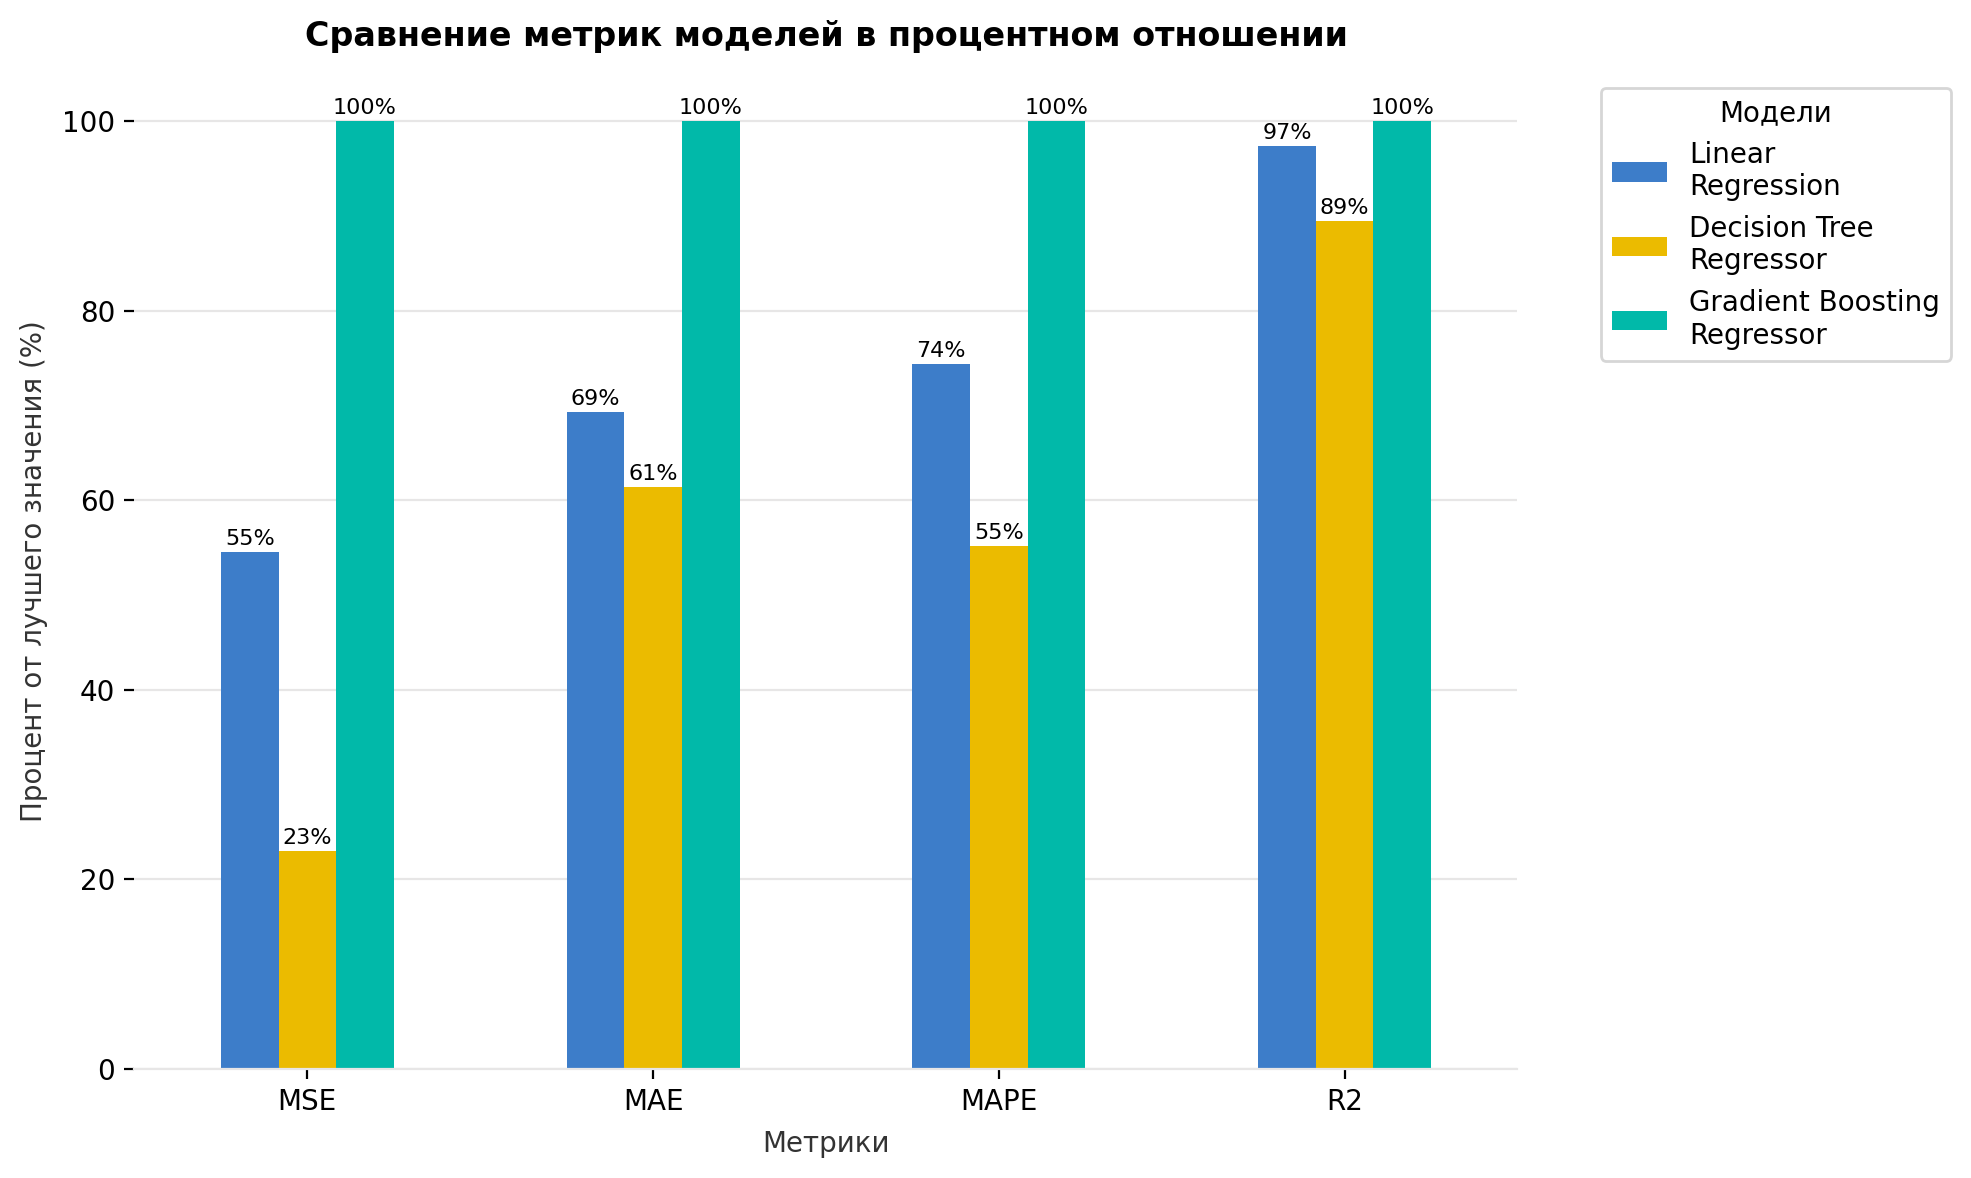

In [2207]:
custom_colors = ['#3D7DC9', '#EBBB00', '#01B9A9']  # синий, оранжевый, зелёный
ax = percentage_df.plot(kind='bar', rot=0, figsize=(10, 6), color=custom_colors)
plt.title('Сравнение метрик моделей в процентном отношении', weight='bold', pad=10)
plt.ylabel('Процент от лучшего значения (%)', labelpad=5, alpha=0.8)
plt.xlabel('Метрики', labelpad=5, alpha=0.8)
plt.legend(title='Модели', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.f%%', padding=1, fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

# Модели для таргета «Удельный расход кокса (кг/т)»

## Масштабирование признаков

In [2208]:
X_train, X_test, y_train, y_test = train_test_split(X_coke, y_coke, test_size=0.2, random_state=42)

In [2209]:
scaler = StandardScaler()

In [2210]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Линейная регрессия

### Обучение модели и вывод метрик

In [2211]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [2212]:
y_pred = model.predict(X_test)

In [2213]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 9.99
MSE: 184.23
MAPE: 2.25%
RMSE: 13.57
R²: 0.65


### График Прогноз-Факт

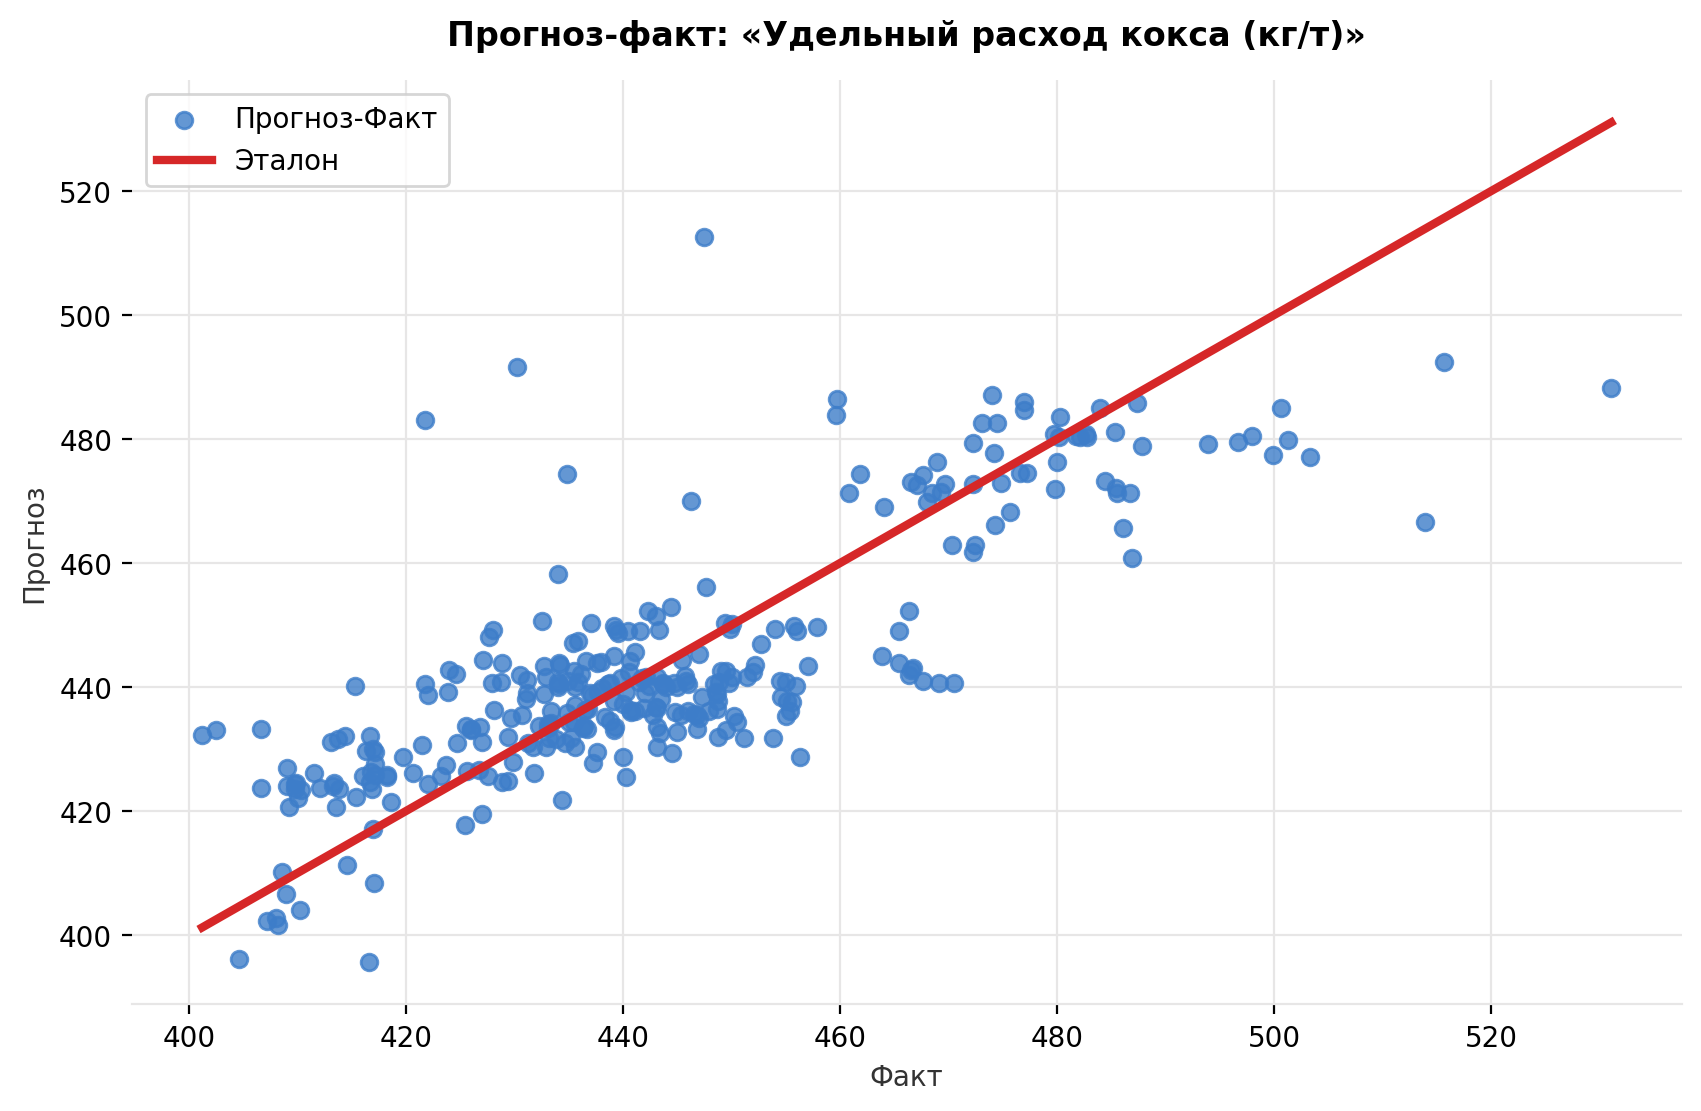

In [2214]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#3D7DC9', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel('Факт', y=1.02, alpha=0.8)
plt.ylabel('Прогноз', x=1.02, alpha=0.8)
plt.title('Прогноз-факт: «Удельный расход кокса (кг/т)»', weight='bold', y=1.02)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.grid(True, color='#E7E6E6')

plt.show()

### График влияния признаков

In [2215]:
coefficients = pd.DataFrame({'Признак': X_coke.columns,'Коэффициент': model.coef_}).sort_values(by='Коэффициент', ascending=True)

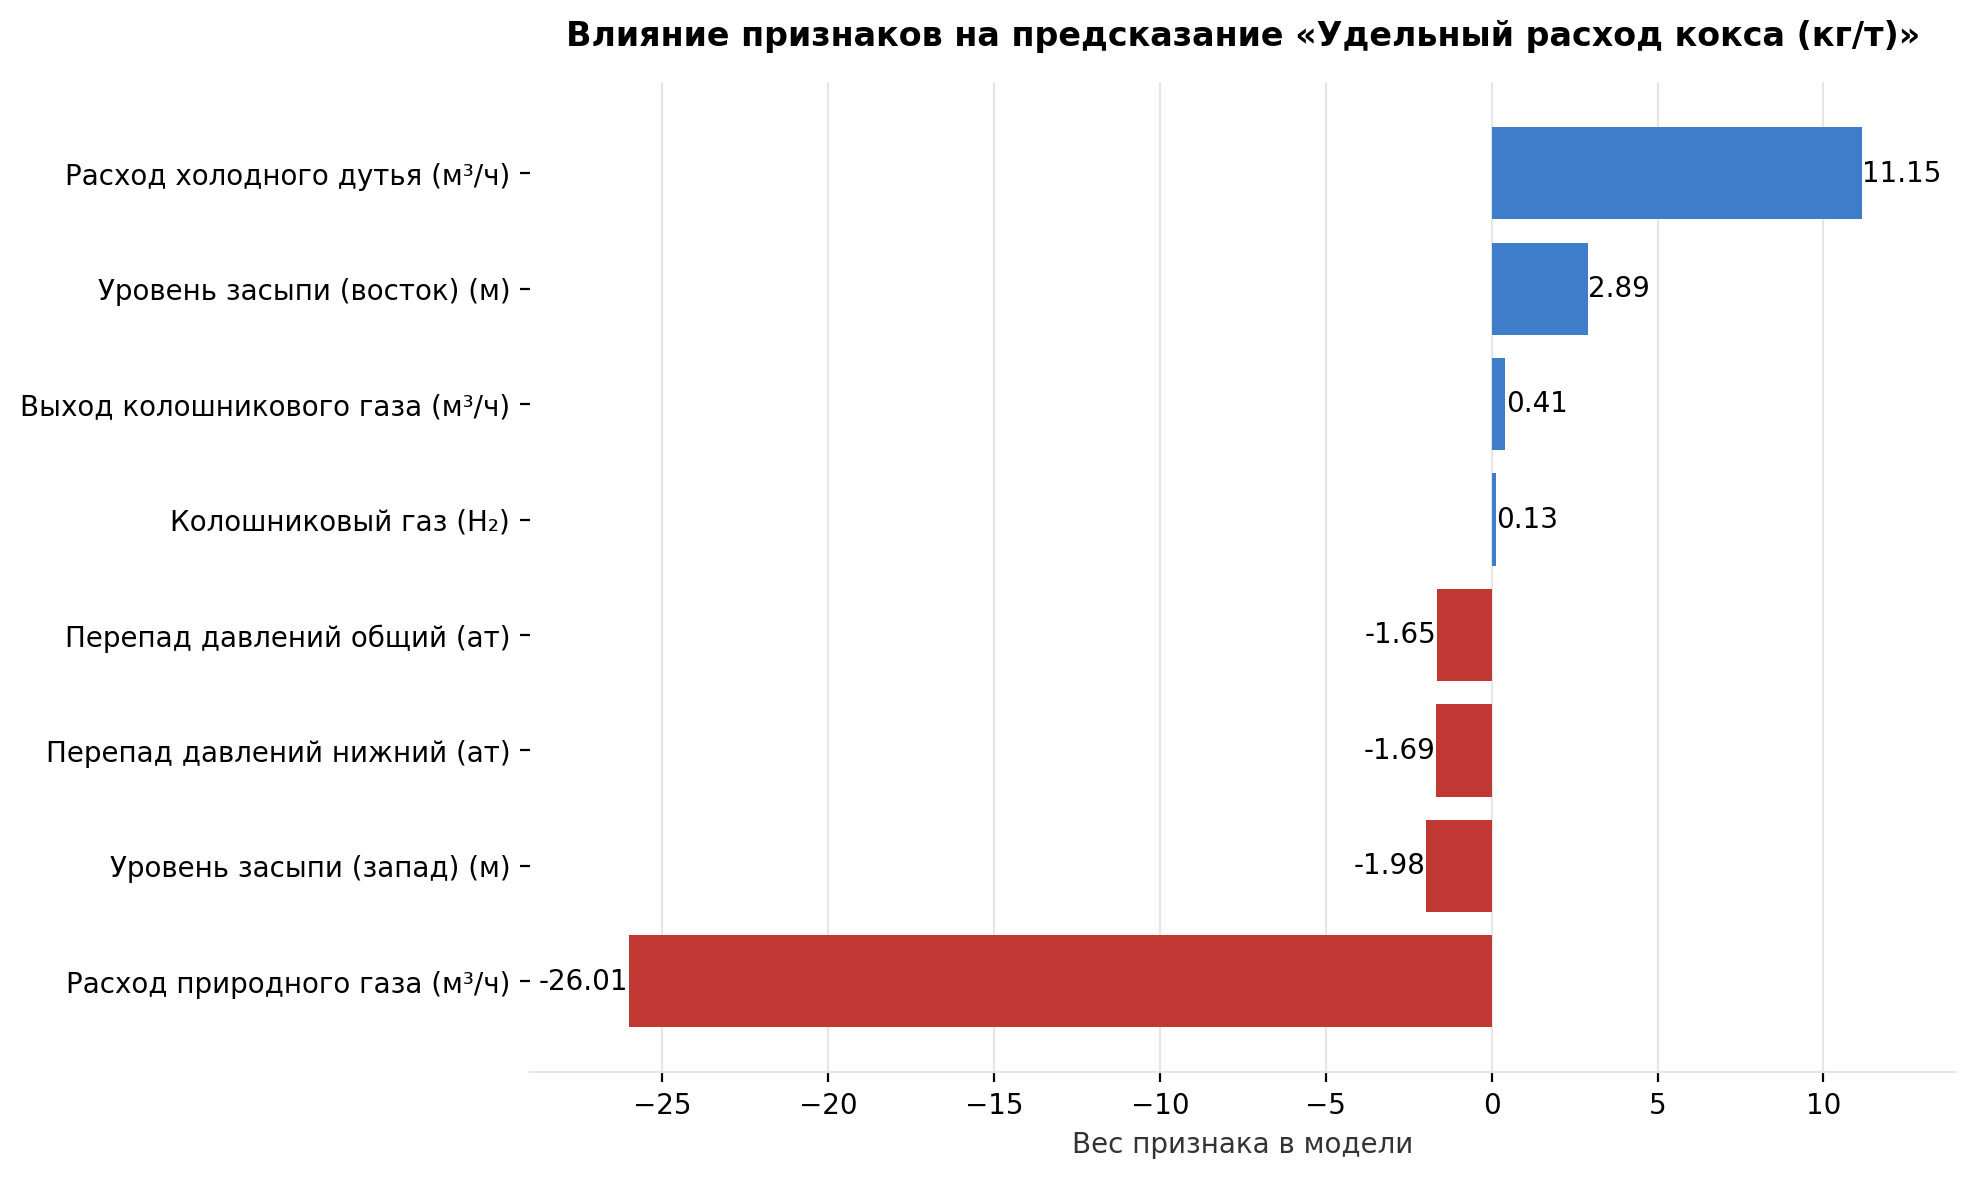

In [2216]:
plt.figure(figsize=(10, 6))
plt.xlim(-29, 14)

colors = ['#3D7DC9' if x >= 0 else '#C13733' for x in coefficients['Коэффициент']]
bars = plt.barh(coefficients['Признак'], coefficients['Коэффициент'], color=colors)

for bar in bars:
    width = bar.get_width()
    align = 'left' if width > 0 else 'right'
    offset = 0.01 if width > 0 else -0.01
    plt.text(width + offset, bar.get_y() + bar.get_height()/2, f'{width:.2f}', ha=align, va='center')

plt.xlabel('Вес признака в модели', y=1.02, alpha=0.8)
plt.title('Влияние признаков на предсказание «Удельный расход кокса (кг/т)»', weight='bold', y=1.02)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.xaxis.grid(True, color='#E7E6E6')

plt.tight_layout()
plt.show()

## Дерево решений

### Подбор гиперпараметров

In [2217]:
tree_model = DecisionTreeRegressor(random_state=42)

In [2218]:
# param_grid = {
#     'max_depth': [6, 7, 8],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [10, 11, 12]
# }

In [2219]:
best_params = {
    'max_depth': [7],
    'max_features': ['log2'],
    'min_samples_leaf': [4],
    'min_samples_split': [11]
}

In [2220]:
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [2221]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 11}

### Обучение модели и вывод метрик

In [2222]:
best_tree = grid_search.best_estimator_

In [2223]:
y_pred = best_tree.predict(X_test)

In [2224]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 10.13
MSE: 192.31
MAPE: 2.27%
RMSE: 13.87
R²: 0.63


### График Прогноз-Факт

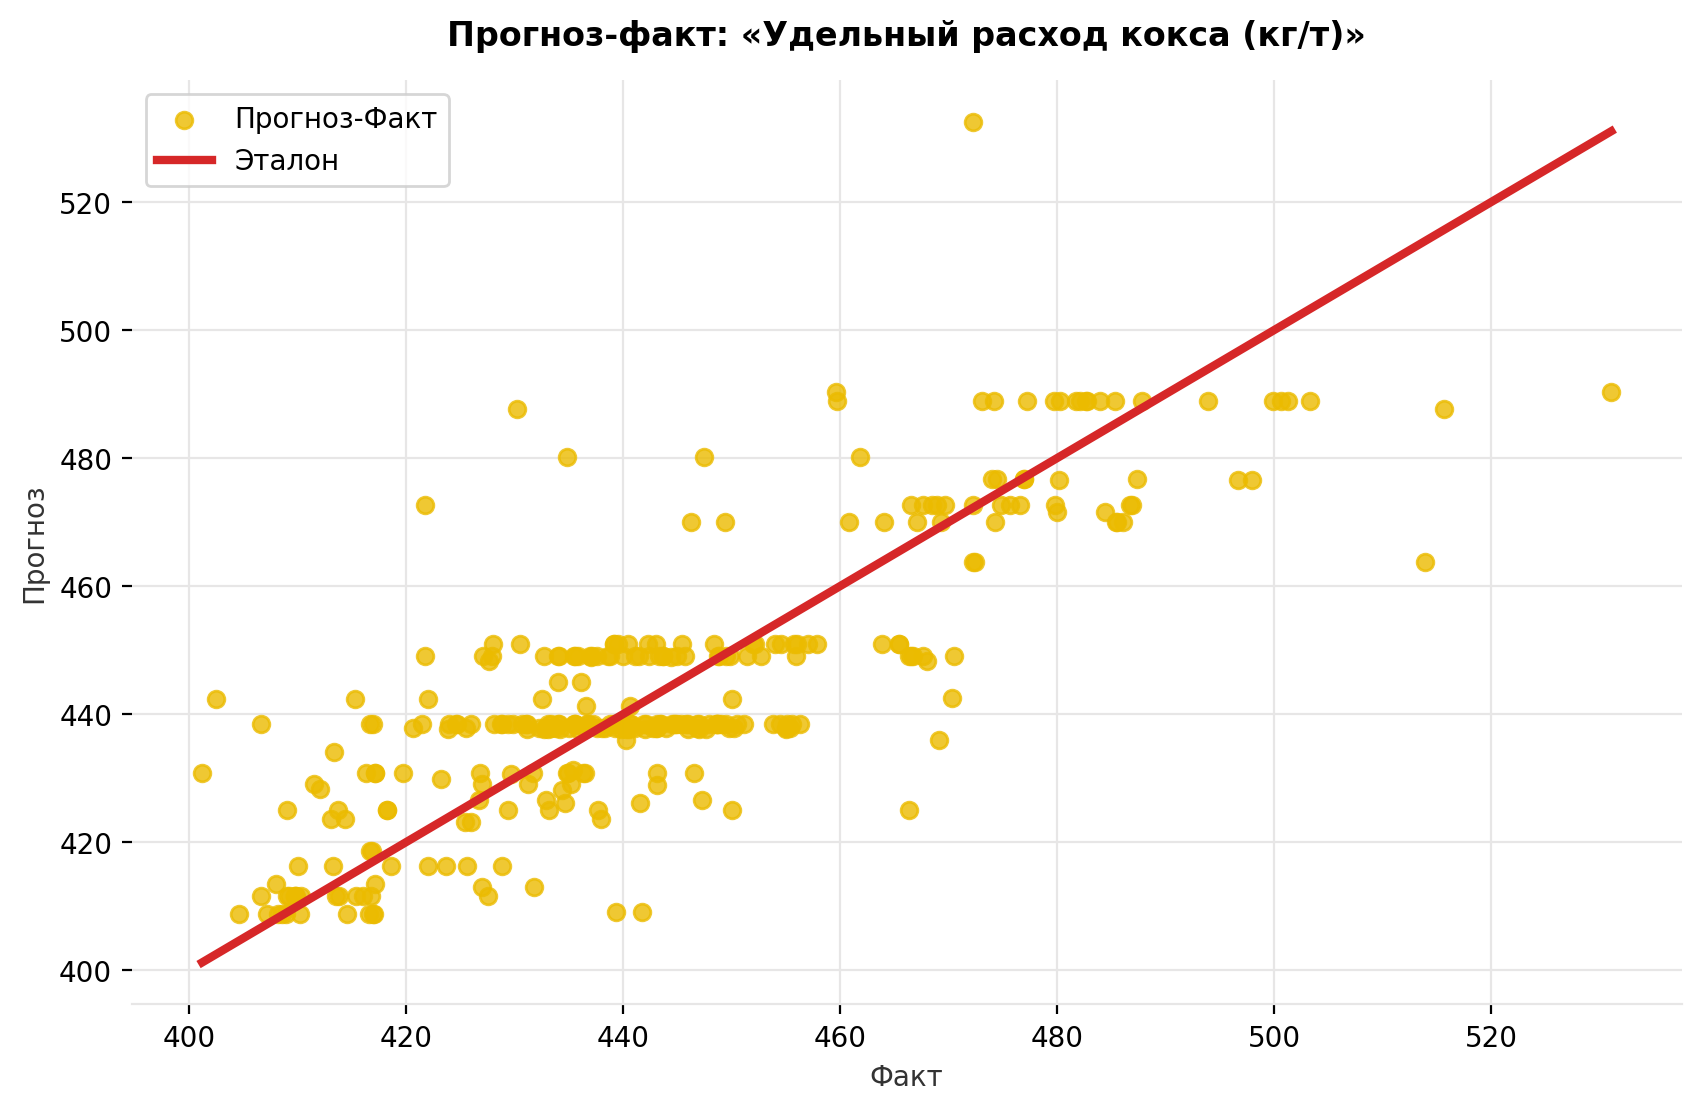

In [2225]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#EBBB00', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel('Факт', y=1.02, alpha=0.8)
plt.ylabel('Прогноз', x=1.02, alpha=0.8)
plt.title('Прогноз-факт: «Удельный расход кокса (кг/т)»', weight='bold', y=1.02)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.grid(True, color='#E7E6E6')

plt.show()

### График важности признаков

In [2226]:
importance = pd.DataFrame({'Признак': X_coke.columns, 'Важность': best_tree.feature_importances_}).sort_values('Важность', ascending=True)

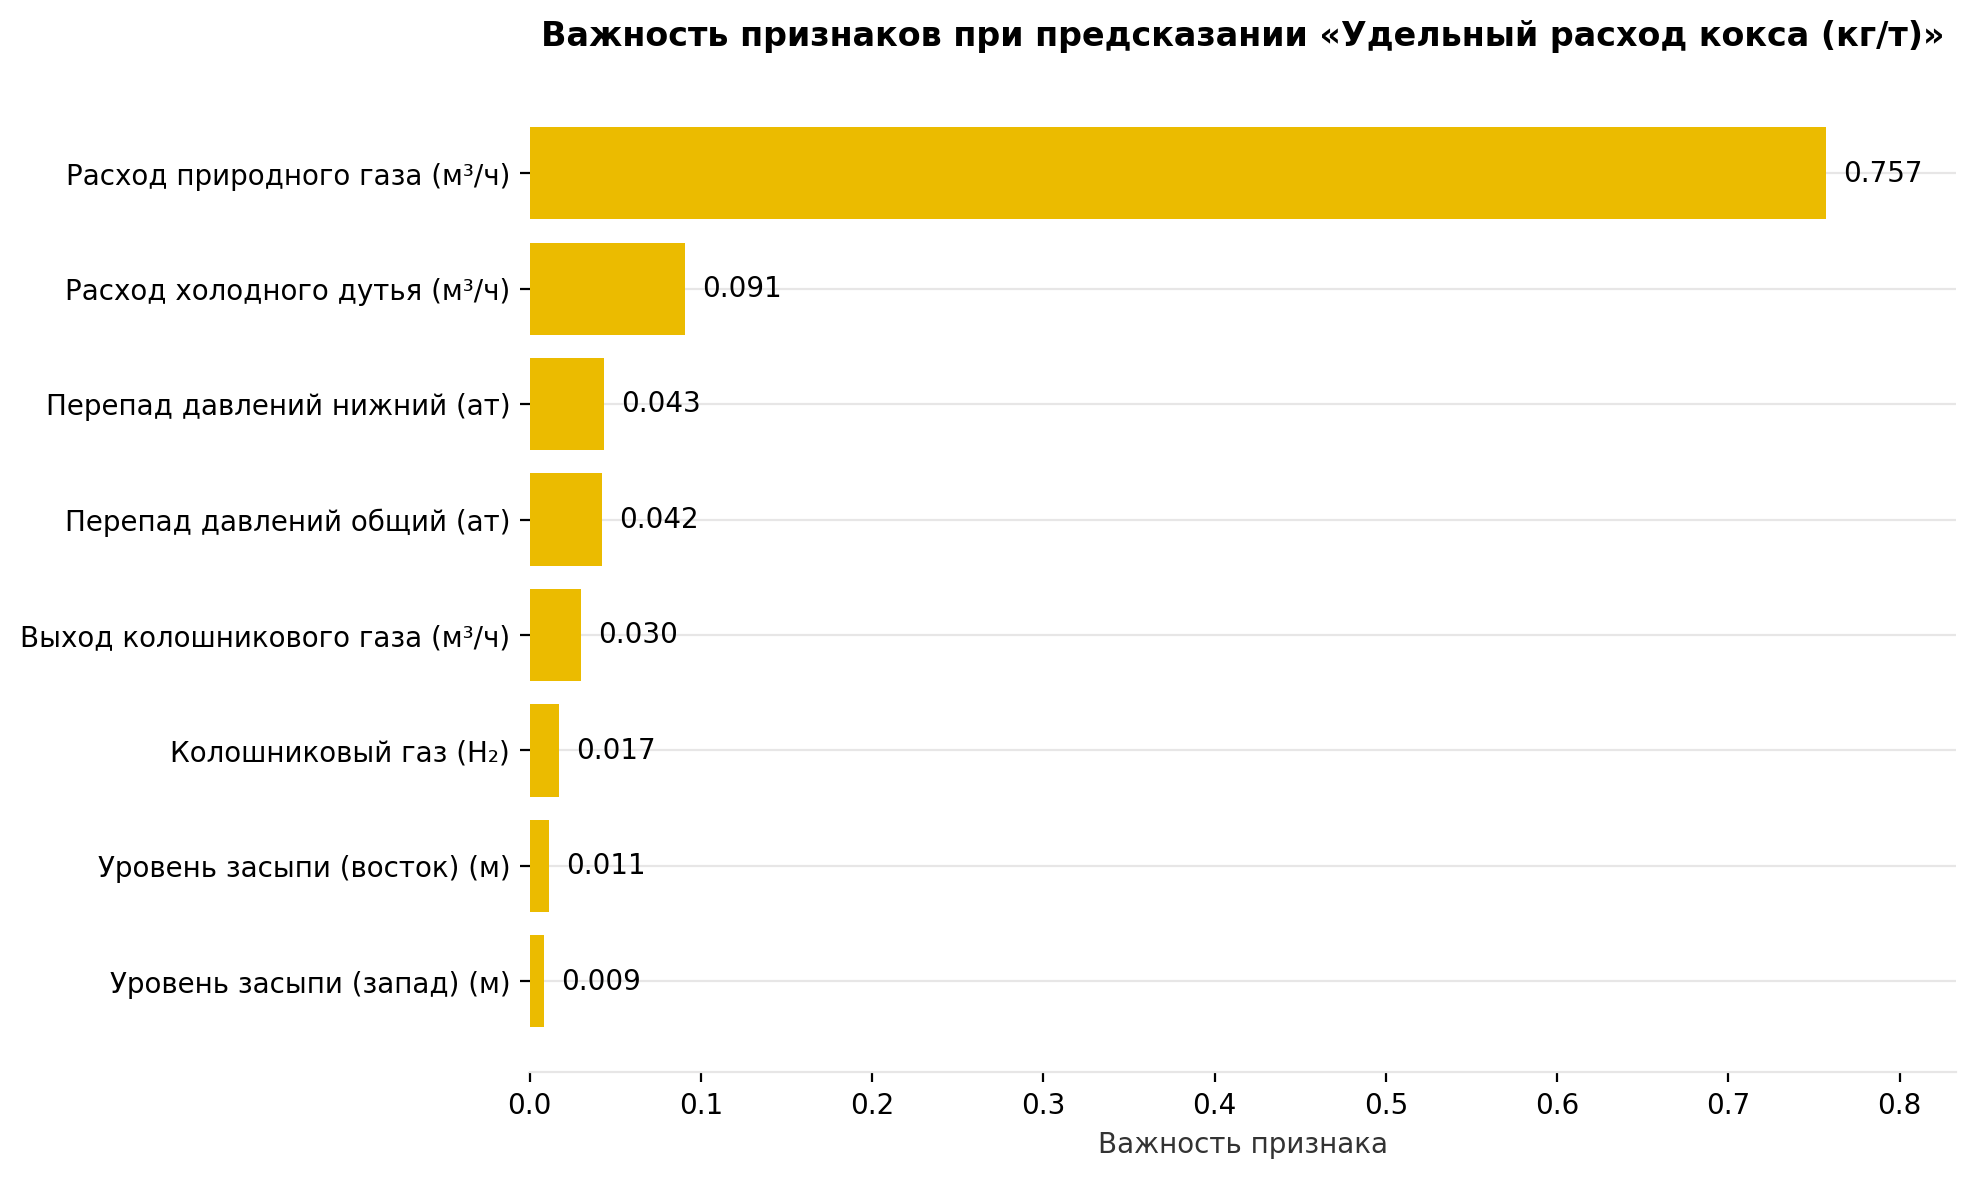

In [2227]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#EBBB00')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака', y=1.02, alpha=0.8)
plt.title('Важность признаков при предсказании «Удельный расход кокса (кг/т)»', weight='bold', y=1.02)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')

plt.tight_layout()
plt.show()

### Визуализация дерева решений

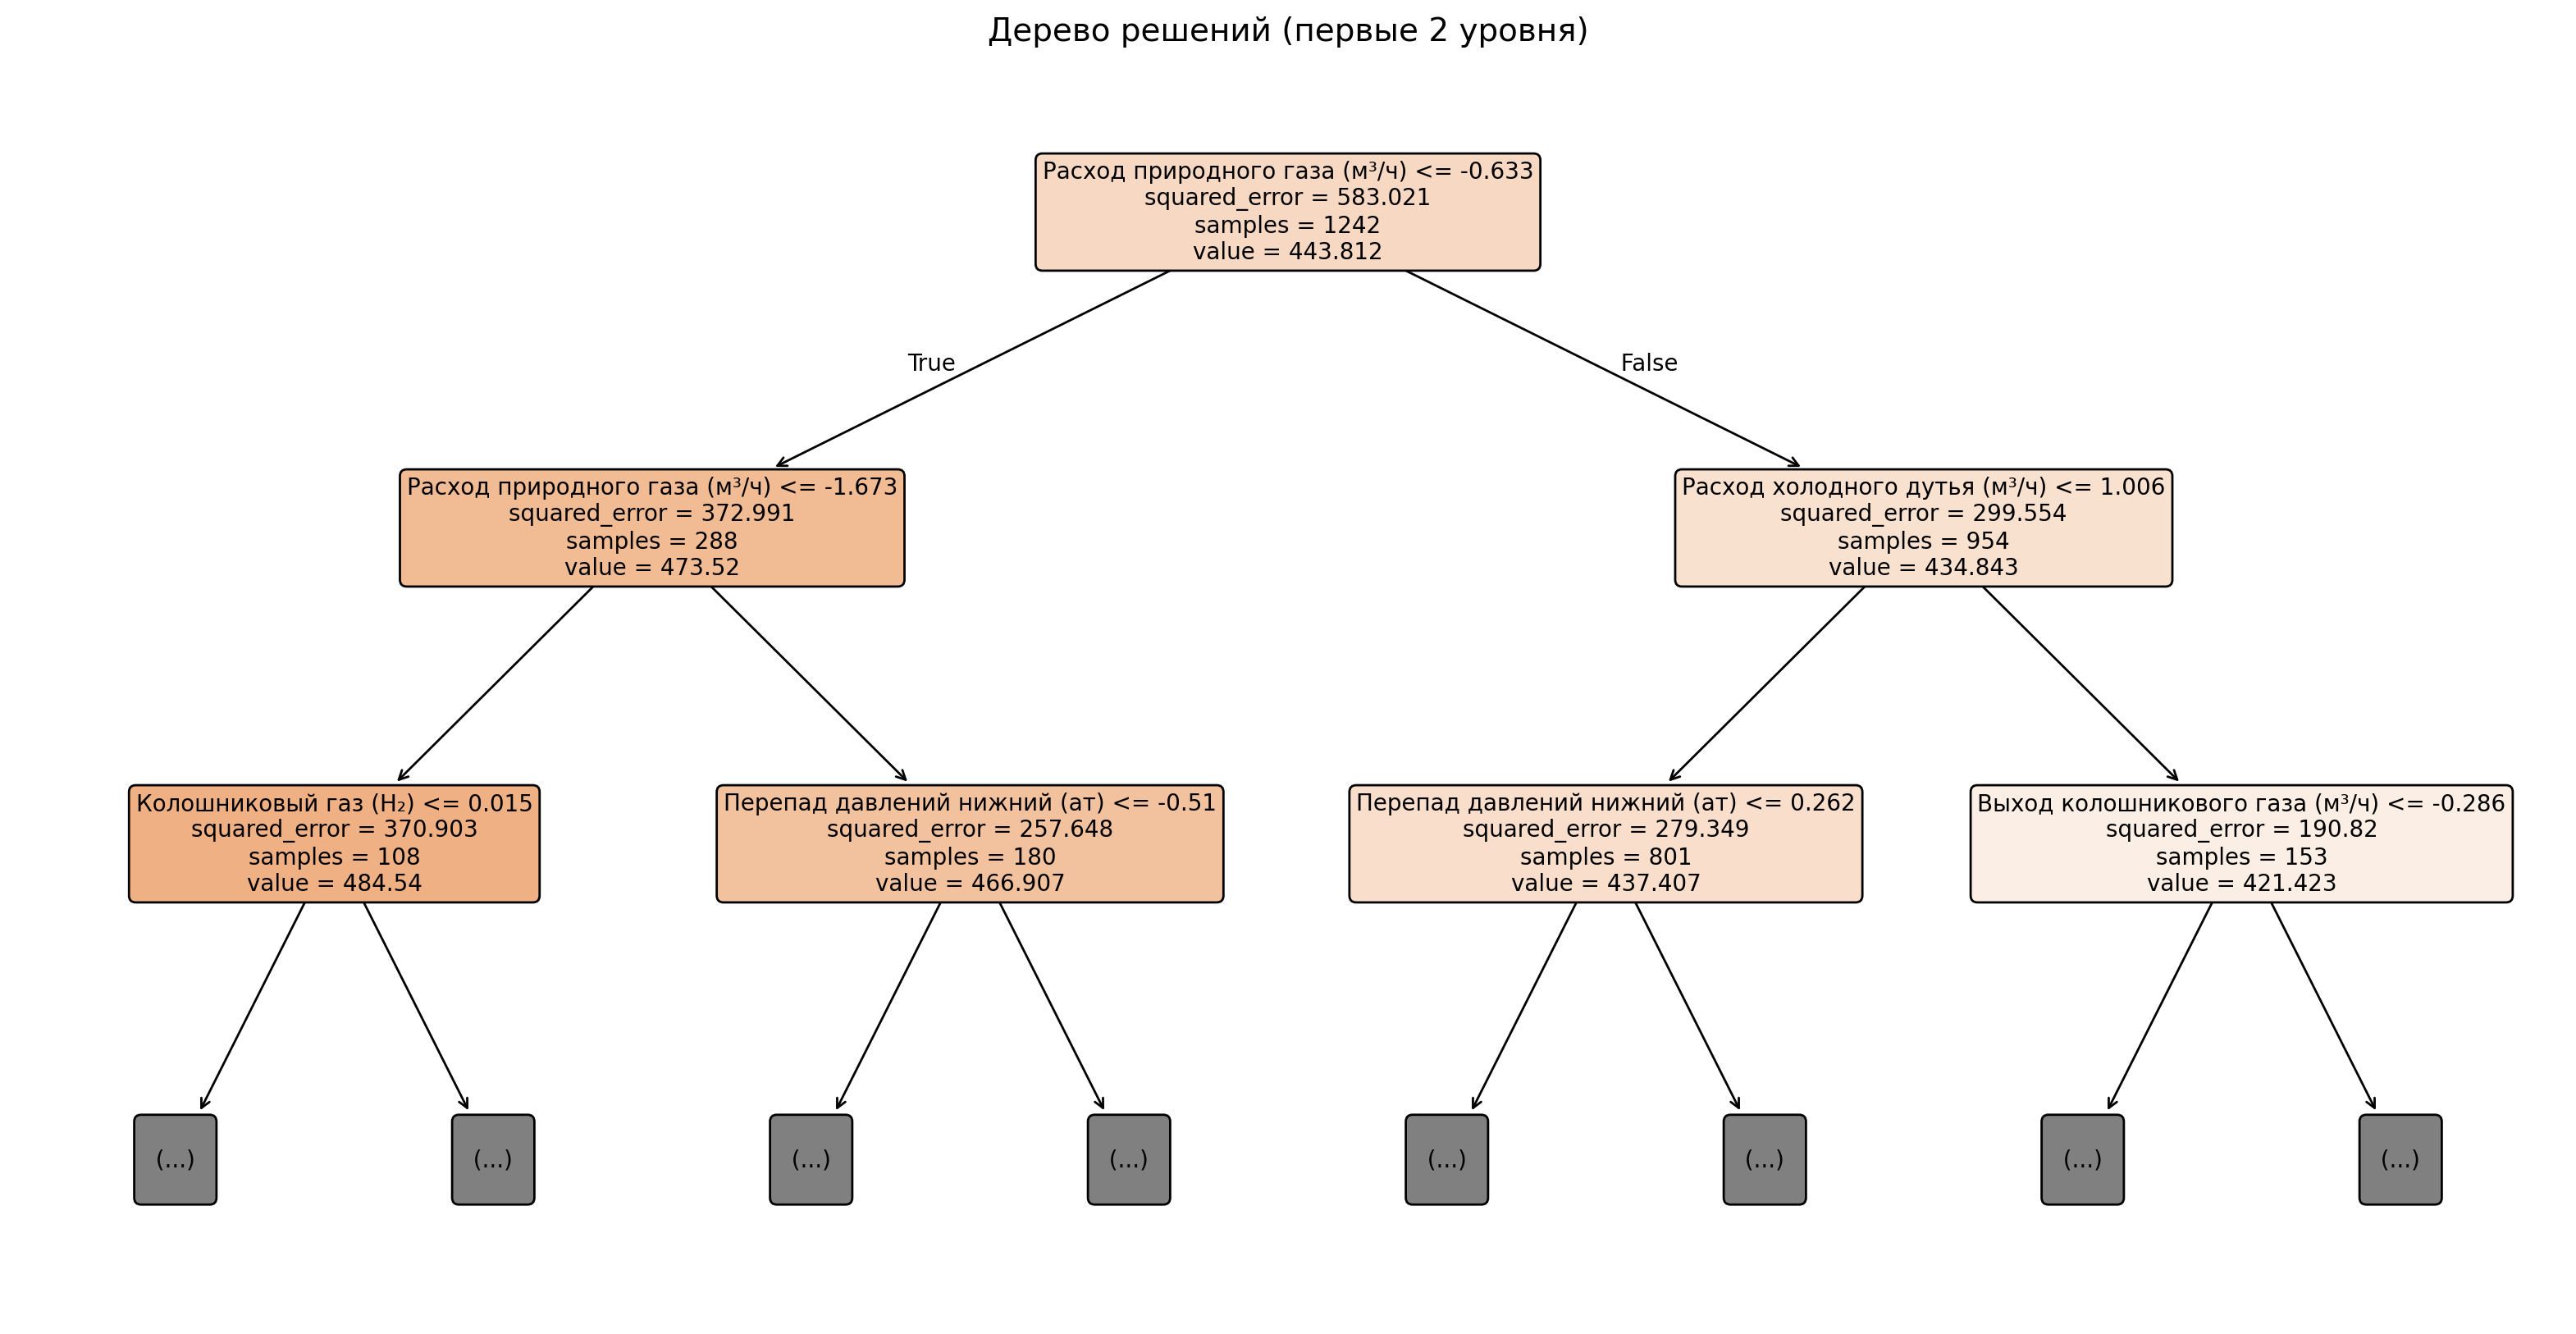

In [2228]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=importance['Признак'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=2,
)
plt.title("Дерево решений (первые 2 уровня)", fontsize=14)
plt.show()

## Градиентный бустинг

### Подбор гиперпараметров

In [2229]:
gb_model = GradientBoostingRegressor(random_state=42)

In [2230]:
# param_grid = {
#     'learning_rate': [0.19, 0.2, 0.21],
#     'max_depth': [7, 8, 9],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [7, 8, 9],
#     'n_estimators': [15, 16, 17]
# }

In [2231]:
best_params = {
    'learning_rate': [0.19, 0.2, 0.21],
    'max_depth': [8],
    'max_features': ['log2'],
    'min_samples_leaf': [2],
    'min_samples_split': [8],
    'n_estimators': [15, 16, 17]
}

In [2232]:
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
)

In [2233]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.19, 0.2, 0.21], 'max_depth': [8],
                         'max_features': ['log2'], 'min_samples_leaf': [2],
                         'min_samples_split': [8],
                         'n_estimators': [15, 16, 17]},
             scoring='neg_mean_squared_error', verbose=1)

In [2234]:
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.2,
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 17}

### Обучение модели и вывод метрик

In [2235]:
best_gb = grid_search.best_estimator_

In [2236]:
import pickle
from google.colab import files

with open('gb_model_coke.pkl', 'wb') as f:
    pickle.dump(best_gb, f)

files.download('gb_model_coke.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2237]:
y_pred = best_gb.predict(X_test)

In [2238]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 7.79
MSE: 127.88
MAPE: 1.74%
RMSE: 11.31
R²: 0.76


### График Прогноз-Факт

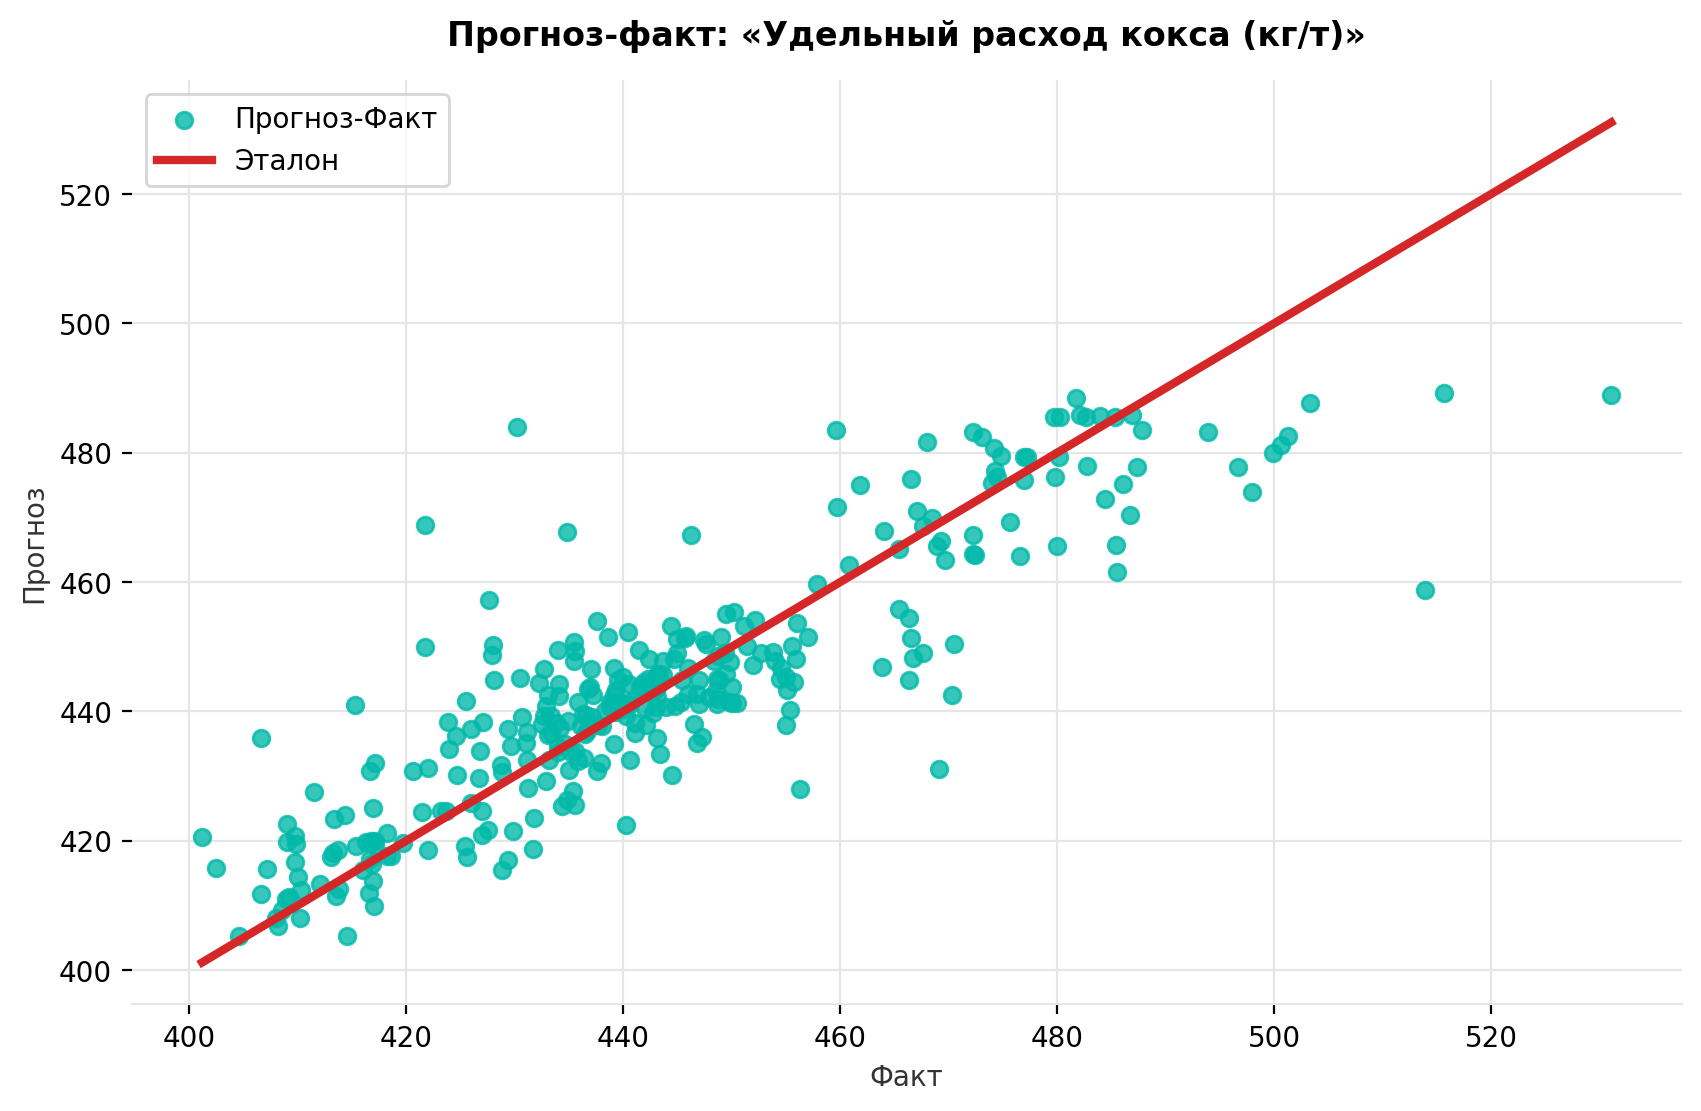

In [2239]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#01B9A9', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel('Факт', y=1.02, alpha=0.8)
plt.ylabel('Прогноз', x=1.02, alpha=0.8)
plt.title('Прогноз-факт: «Удельный расход кокса (кг/т)»', weight='bold', y=1.02)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.grid(True, color='#E7E6E6')

plt.show()

### График важности признаков

In [2240]:
importance = pd.DataFrame({'Признак': X_coke.columns, 'Важность': best_gb.feature_importances_}).sort_values('Важность', ascending=True)

In [2241]:
# importance = pd.DataFrame({'Признак': X_coke.columns, 'Важность': best_gb.feature_importances_}).sort_values('Важность', ascending=True).tail(3)

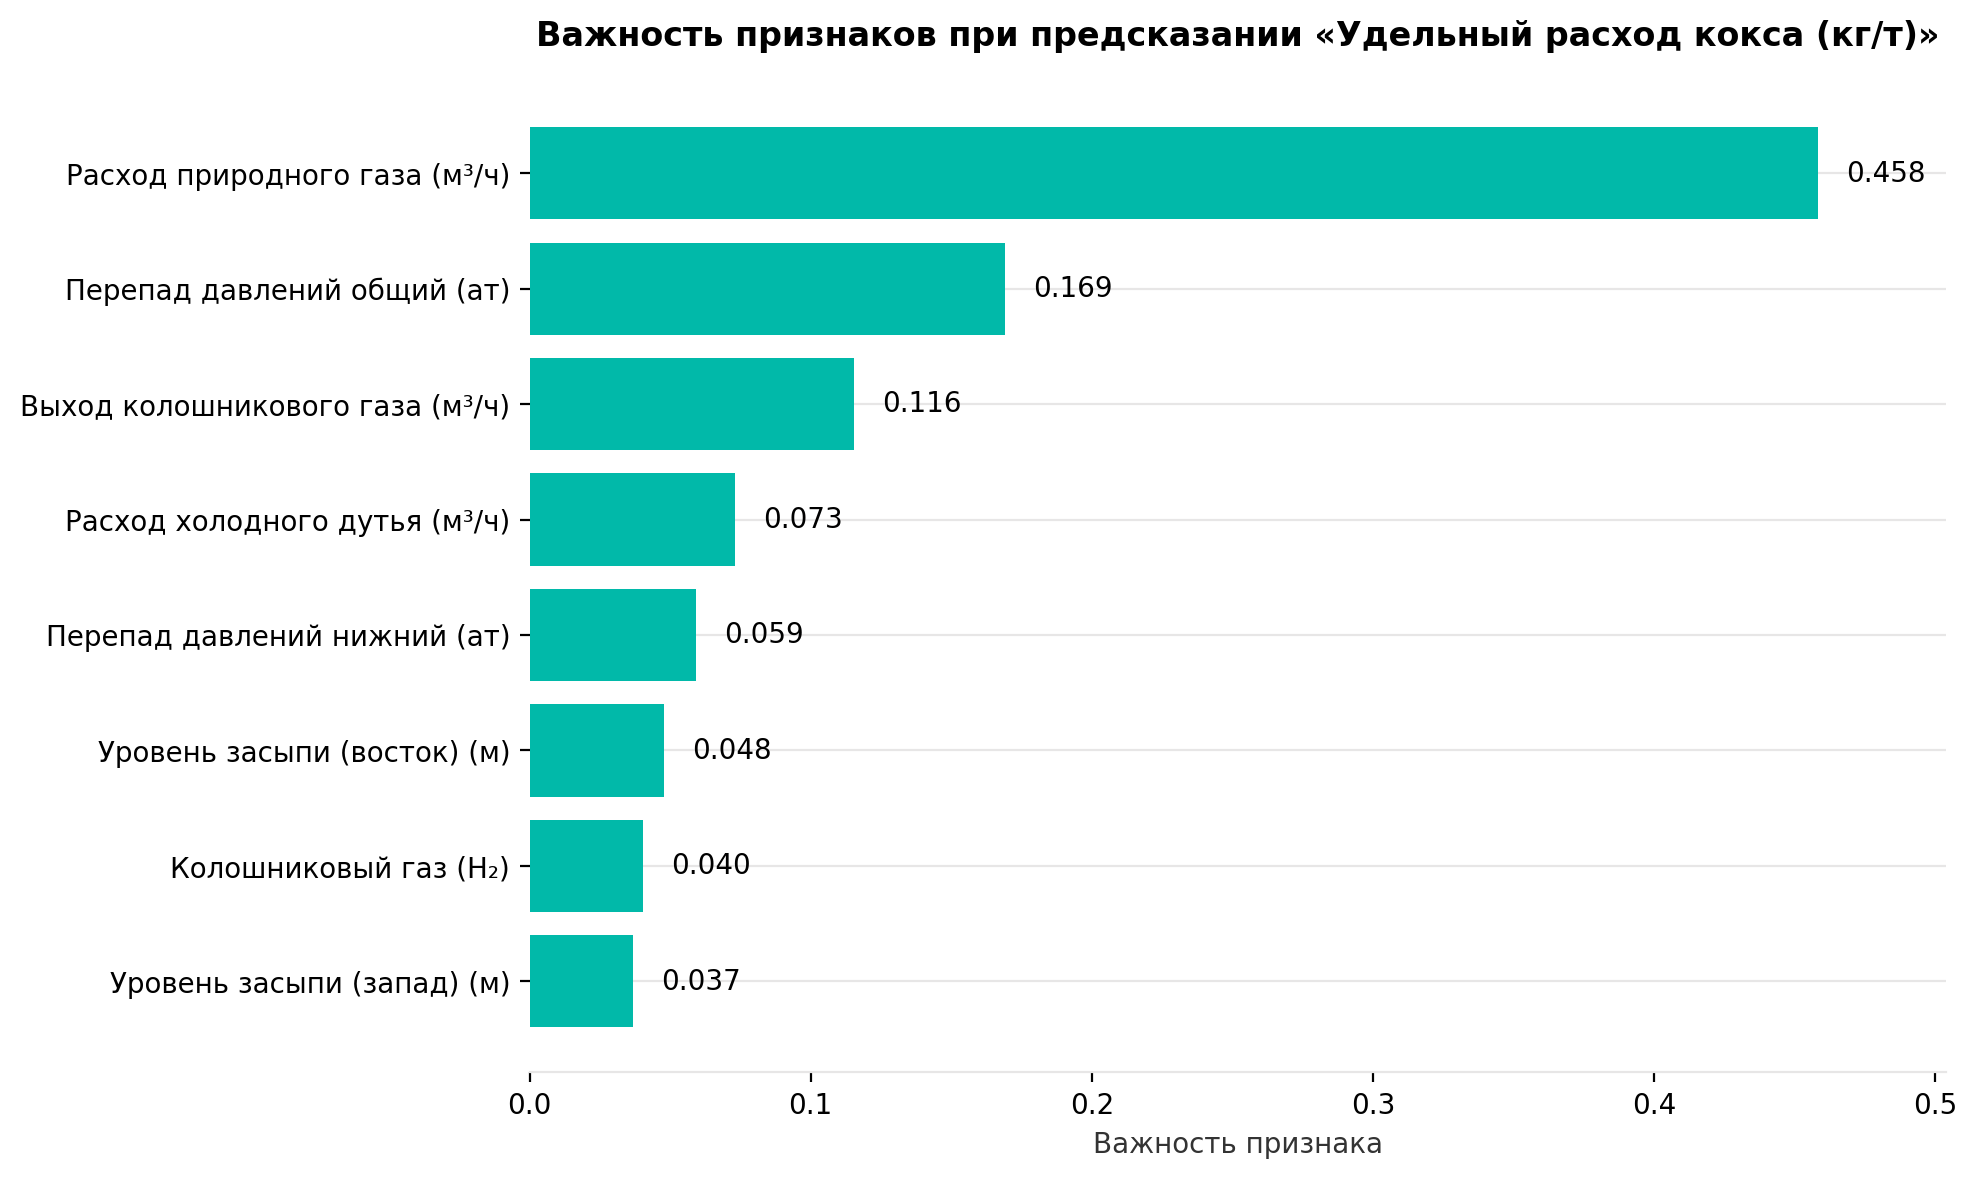

In [2242]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#01B9A9')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака', y=1.02, alpha=0.8)
plt.title('Важность признаков при предсказании «Удельный расход кокса (кг/т)»', weight='bold', y=1.02)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')

plt.tight_layout()
plt.show()

## Сравнение метрик моделей

In [2243]:
y_pred_model = model.predict(X_test)
y_pred_tree = best_tree.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

In [2244]:
metrics_model = evaluate_model(y_test, y_pred_model)

Метрики модели:
MAE: 9.99
MSE: 184.23
MAPE: 2.25%
RMSE: 13.57
R²: 0.65


In [2245]:
metrics_tree = evaluate_model(y_test, y_pred_tree)

Метрики модели:
MAE: 10.13
MSE: 192.31
MAPE: 2.27%
RMSE: 13.87
R²: 0.63


In [2246]:
metrics_gb = evaluate_model(y_test, y_pred_gb)

Метрики модели:
MAE: 7.79
MSE: 127.88
MAPE: 1.74%
RMSE: 11.31
R²: 0.76


In [2247]:
all_metrics = {
    'Linear\nRegression': metrics_model,
    'Decision Tree\nRegressor': metrics_tree,
    'Gradient Boosting\nRegressor': metrics_gb
}

In [2248]:
metrics_df = pd.DataFrame(all_metrics).T

In [2249]:
def convert_to_percentage(df):
    percentage_df = pd.DataFrame()

    for metric in ['MSE', 'MAE', 'MAPE']:
        best_value = df[metric].min()
        percentage_df[metric] = (best_value / df[metric]) * 100

    for metric in ['R2']:
        best_value = df[metric].max()
        percentage_df[metric] = (df[metric] / best_value) * 100

    return percentage_df

In [2250]:
percentage_df = convert_to_percentage(metrics_df).T

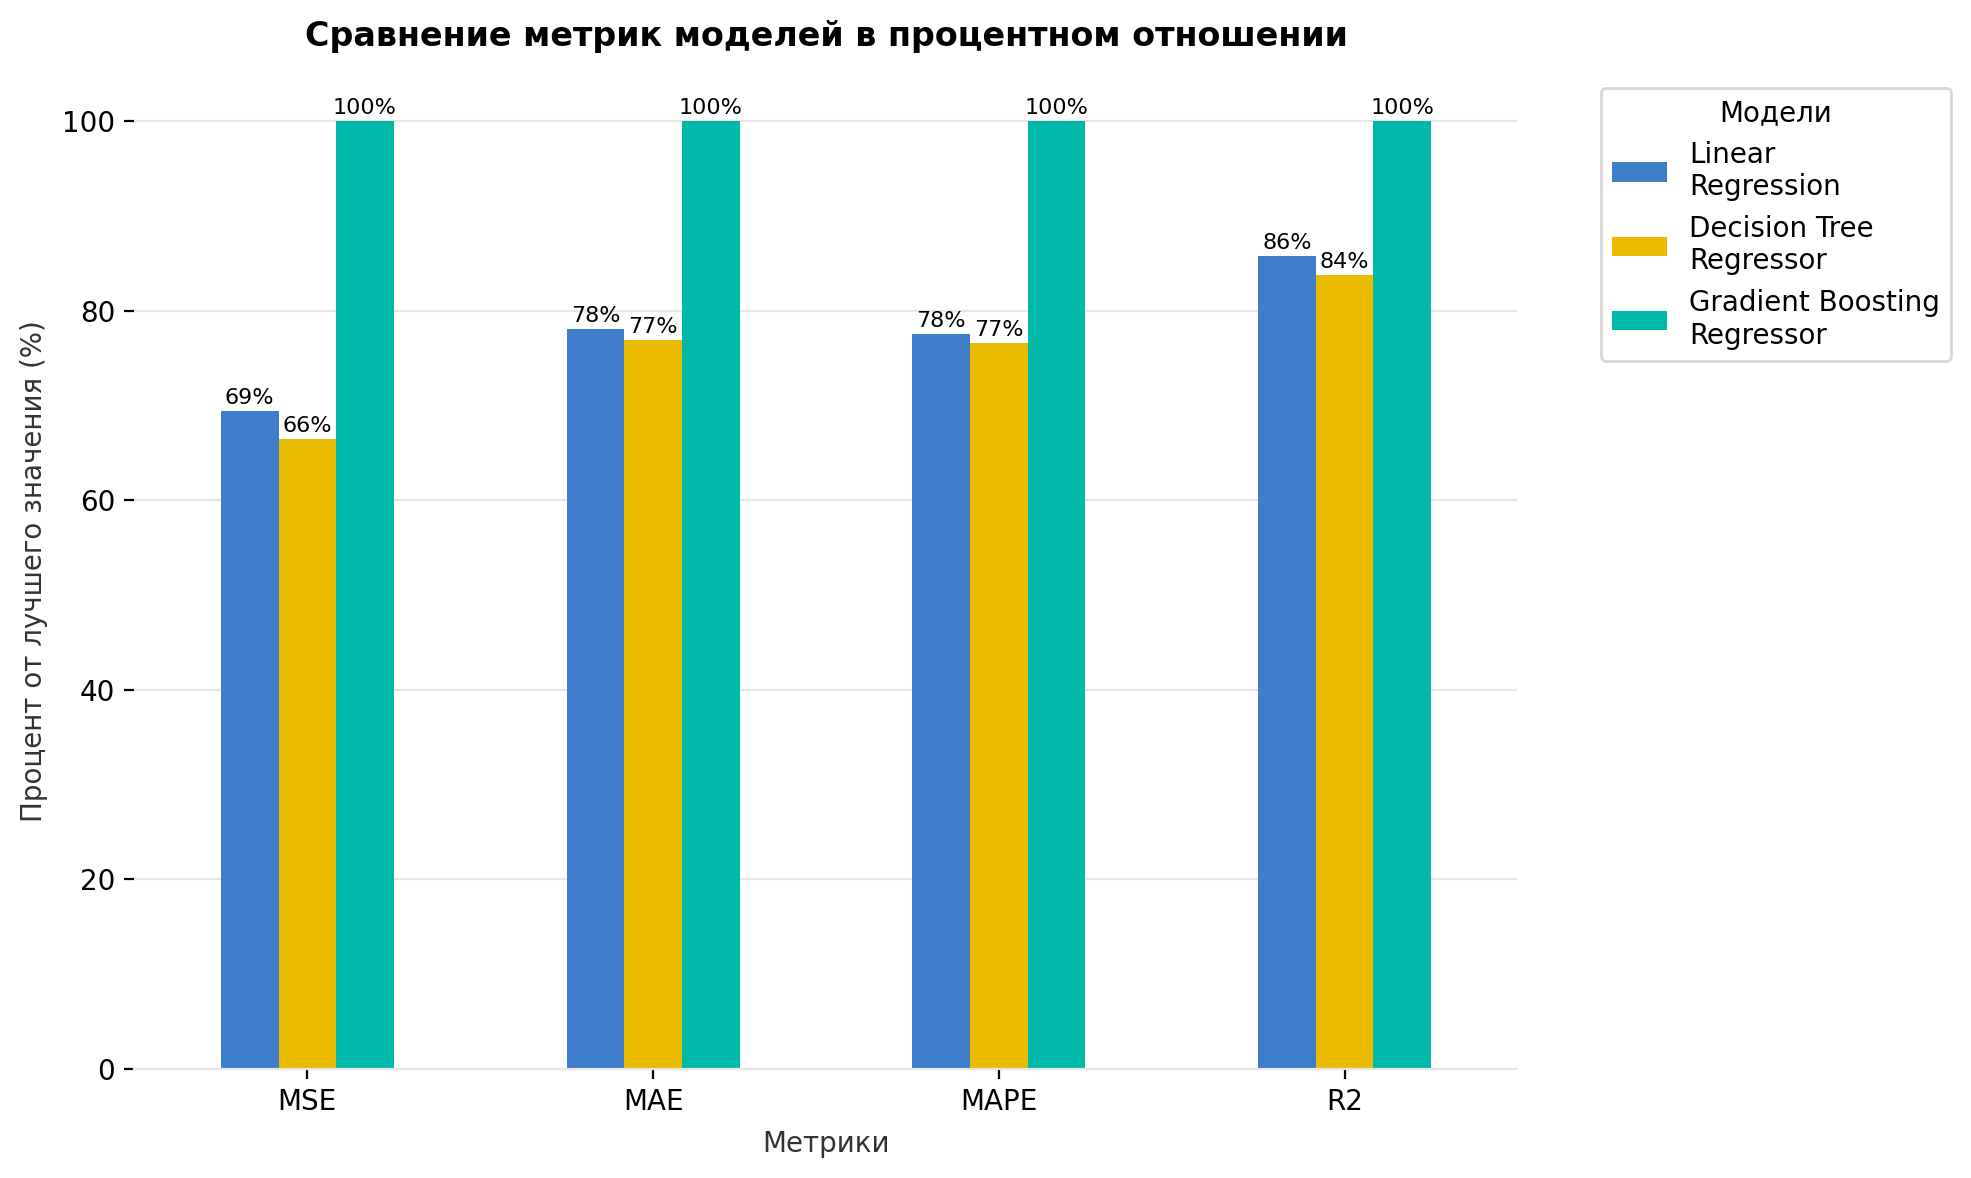

In [2251]:
custom_colors = ['#3D7DC9', '#EBBB00', '#01B9A9']  # синий, оранжевый, зелёный
ax = percentage_df.plot(kind='bar', rot=0, figsize=(10, 6), color=custom_colors)
plt.title('Сравнение метрик моделей в процентном отношении', weight='bold', pad=10)
plt.ylabel('Процент от лучшего значения (%)', labelpad=5, alpha=0.8)
plt.xlabel('Метрики', labelpad=5, alpha=0.8)
plt.legend(title='Модели', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.f%%', padding=1, fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()